5 W and H

- Why should we learn to handle noisy and imbalanced datasets
    - Noise: Most real world datasets will have some noise since the labels may not be expert generated, or due to equipment issues.
    - Imbalance: Lots of datasets like fraud/disease detection have very low positive rates but lots of data

- Why we did with concepts
- What we did
- What impact/difference it made in perf?
- Allow other datasets like titanic and housing price to be used by making modular.
- provide interactive controls for both model and data generation
- Provide ways to visualize these issues and show how we can leverage this on a real world dataset.
- After Classification show correct and erroroneous classification
- Enable plotting of results of various experiments overall. 
    - Noise plot: Increase noise how does metric change
    - Imbalance plot: Increase imbalance how does metric change
    
- Put well commented `your X here` for other people to experiment

# References

[Install Imbalanced Learn](https://imbalanced-learn.readthedocs.io/en/stable/install.html)

[Install XGBoost]()

`pip install --upgrade --upgrade-strategy only-if-needed https://github.com/faizanahemad/data-science-utils/tarball/master`

`pip install keras`

`pip install tensorflow`

`pip install missingno`

[Install IpyWidgets for Interactive Simulation](https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6)

[Using Ipywidgets](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html)


[Plotly Installation](https://plot.ly/python/getting-started/)



- Signal to Noise Ratio
    - stopwords in NLP
    - Images and Denoising Auto-Encoders
- Importance of knowing noise levels in your data. This determines the maximum accuracy/other metric that your model can perform.
- Recognizing the type of noise. 
    - Is it near the decision boundary (few ambigous samples marked wrong). This is good, most models are robust to this.
    - Is it randomly spread (Makes things hard)
- Seeing how imbalance combined with noise impact performance.
    - Choosing the right metric for class imbalance problems. e.g. FP rate, AP, instead of Accuracy.
        - Show this by plotting imbalance in x-axis and metric in y for multiple metrics
    - Notice how adding imbalance makes it difficult for model to get both high precision and recall.
    - Adding over-sampling methods for NNs and scale_pos_weight for XGBoost to deal with class imabalance. We will try dumb oversampling only.
    - At what point of imbalance does over-sampling help, and what does it imply for our metrics
    
- Precautions to take while over-sampling in presence of noise.
- Recognising overfit especially in boundary noise conditions and imbalance by using Cross Validation.


[XGBoost validation plots](https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/)

# Imports and Libs

In [155]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
from matplotlib import pyplot as plt

import pandas as pd
from pandas import DataFrame
import more_itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.impute import SimpleImputer

from multiprocessing import Pool
from xgboost import XGBClassifier
import multiprocessing

pd.options.display.max_rows=900
pd.options.display.max_columns=900

%matplotlib inline
import seaborn as sns
from IPython.display import display

from data_science_utils import dataframe as df_utils
from data_science_utils import models as model_utils
from data_science_utils import plots as plot_utils
from data_science_utils.dataframe import column as column_utils
from data_science_utils import misc as misc
from data_science_utils import preprocessing as pp_utils

import warnings
import traceback
np.set_printoptions(threshold=np.nan)
warnings.filterwarnings('ignore')
import sys, os
import missingno as msno
import random
import gc

pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import RUSBoostClassifier


In [2]:
import plotly
plotly.__version__
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)


'3.7.0'

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from data_science_utils.dataframe import get_specific_cols

from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import regularizers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import BaseWrapper
from keras.layers import Dense, Activation
from keras import optimizers
from keras import backend as K
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TerminateOnNaN

_EPSILON = K.epsilon()

def log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    out = -(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
    return K.mean(out, axis=-1)

def root_mean_squared_error(y_true, y_pred):
    # error = K.square((1-y_true)*(y_pred - y_true)+(4*y_true)*(y_pred - y_true))
    error = K.square((y_pred - y_true))
    return K.sqrt(K.mean(error, axis=-1))

class BinaryClassifierKerasDNN:
    def __init__(self, network_config,lr=0.005,
                 n_iter=[500,500,500], columns=[],
                 scale_input=True, impute=True, raise_null=True,verbose=False,plot=True):
        self.network_config = network_config
        self.columns = columns
        assert len(columns) > 0 or prefixes is not None
        self.scale_input = scale_input
        self.scaler = StandardScaler()
        self.impute = impute
        self.imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        self.imp_inf = SimpleImputer(missing_values=np.inf, strategy='mean')
        self.raise_null = raise_null
        self.cols = None
        self.n_iter = n_iter
        self.verbose = verbose
        self.plot = plot
        self.lr = lr

    def check_null_(self, X):
        nans = np.isnan(X)
        infs = np.isinf(X)
        nan_summary = np.sum(np.logical_or(nans, infs))
        if nan_summary > 0:
            raise ValueError("nans/inf in frame = %s" % (nan_summary))

    def get_cols_(self, X):
        cols = list(self.columns)
        return cols

    def fit(self, X, y, sample_weight=None):
        cols = self.get_cols_(X)
        self.cols = cols
        X = X[cols]
                
        from sklearn.utils import shuffle
        X, y = shuffle(X, y)
            
            
        if self.impute:
            X = self.imp.fit_transform(X)
            X = self.imp_inf.fit_transform(X)
        if self.scale_input:
            X = self.scaler.fit_transform(X)
        if self.raise_null:
            self.check_null_(X)
            
        model = Sequential()
        i = 0
        for layer in self.network_config:
            if i==0:
                model.add(Dense(layer['neurons'],activation=layer['activation'],input_dim=X.shape[1],use_bias=True))
                if "dropout" in layer:
                    model.add(Dropout(layer["dropout"]))
                else:
                    model.add(Dropout(0.2))
            else:
                model.add(Dense(layer['neurons'],activation=layer['activation'],use_bias=True))
                if "dropout" in layer:
                    model.add(Dropout(layer["dropout"]))
                else:
                    model.add(Dropout(0.1))
            i=i+1
        model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
        
        adam = optimizers.Adam(lr=self.lr, clipnorm=2, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
        model.compile(optimizer=adam, loss=log_loss)
        
        
        X1,X2,X3 = np.split(X, [int(.33*len(X)), int(.66*len(X))])
        y1,y2,y3 = np.split(y, [int(.33*len(y)), int(.66*len(y))])
        
        X1,X2,X3 = pd.DataFrame(X1),pd.DataFrame(X2),pd.DataFrame(X3)
        y1,y2,y3 = pd.Series(y1),pd.Series(y2),pd.Series(y3)
        
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.0000005,epsilon=0.0001)
        reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=3, min_lr=0.0000005,epsilon=0.00001)
        terminate_on_nan = TerminateOnNaN()
        es = EarlyStopping(monitor='val_loss', min_delta=0.000001, patience=12, verbose=0,)
        es2 = EarlyStopping(monitor='val_loss', min_delta=0.000001, patience=10, verbose=0,)
        # print(K.get_value(model.optimizer.lr))
        X_train,y_train,X_val,y_val = pd.concat((X1,X2),axis=0),pd.concat((y1,y2),axis=0),X3,y3
        training_loss = []
        test_loss = []
        history = model.fit(X_train, y_train,
                        epochs=self.n_iter[0],
                        batch_size=1024,
                        shuffle=True,
                        validation_data=(X_val, y_val),
                        verbose=self.verbose,
                        callbacks=[es,terminate_on_nan,reduce_lr])
        training_loss.extend(history.history['loss'])
        test_loss.extend(history.history['val_loss'])
        # K.set_value(model.optimizer.lr, self.lr/2)
        # print(K.get_value(model.optimizer.lr))
        
        X_train,y_train,X_val,y_val = pd.concat((X2,X3),axis=0),pd.concat((y2,y3),axis=0),X1,y1
        history = model.fit(X_train, y_train,
                        epochs=self.n_iter[1],
                        batch_size=1024,
                        shuffle=True,
                        validation_data=(X_val, y_val),
                        verbose=self.verbose,
                        callbacks=[es2,terminate_on_nan,reduce_lr2])
        training_loss.extend(history.history['loss'])
        test_loss.extend(history.history['val_loss'])
        
        # print(K.get_value(model.optimizer.lr))
        K.set_value(model.optimizer.lr, self.lr/100)
        # print(K.get_value(model.optimizer.lr))
        
        X_train,y_train,X_val,y_val = pd.concat((X1,X3),axis=0),pd.concat((y1,y3),axis=0),X2,y2
        history = model.fit(X_train, y_train,
                        epochs=self.n_iter[2],
                        batch_size=4096,
                        shuffle=True,
                        validation_data=(X_val, y_val),
                        verbose=self.verbose,
                        callbacks=[es2,terminate_on_nan,reduce_lr2])
        training_loss.extend(history.history['loss'])
        test_loss.extend(history.history['val_loss'])
        # print(K.get_value(model.optimizer.lr))
        
        if self.plot:
            plt.figure(figsize=(14,10))
            plt.plot(training_loss,label="Training Loss")
            plt.plot(test_loss,label="Test Loss")
            plt.title("Training and Test Loss (Last 3 Training): %s (Last 3 Test): %s"%(training_loss[-3:],test_loss[-3:]))
            plt.ylim((min(min(training_loss),min(test_loss)),min(max(training_loss),max(test_loss))))
            plt.legend()
            plt.show()
        
        
        gc.collect()
        self.classifier = model
        return self

    def partial_fit(self, X, y):
        return self.fit(X, y)

    def predict_proba(self, X, y='ignored'):
        Inp = X
        cols = self.cols
        Inp = Inp[cols]
        if self.impute:
            Inp = self.imp.transform(Inp)
            Inp = self.imp_inf.transform(Inp)
        if self.scale_input:
            Inp = self.scaler.transform(Inp)

        if self.raise_null:
            self.check_null_(Inp)
        probas = self.classifier.predict(Inp)
        gc.collect()
        return probas
    
    def predict(self,X,y='ignored'):
        return self.predict_proba(X)>0.5

    def inverse_transform(self, X, copy=None):
        raise NotImplementedError()

    def fit_transform(self, X, y, sample_weight=None):
        self.fit(X, y, sample_weight=sample_weight)
        return self.transform(X, y)

In [152]:
def moving_average(a, n=5,padding=2):
    a = np.concatenate((np.array(a[0:padding]),a,np.array(a[-padding-1:-1])))
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def hampel(vals_orig, k=6, t0=2):
    '''
    vals: pandas series of values from which to remove outliers
    k: size of window (including the sample; 7 is equal to 3 on either side of value)
    '''

    #Make copy so original not edited
    vals = pd.Series(vals_orig).copy()

    #Hampel Filter
    L = 1.4826
    rolling_median = vals.rolling(window=k, center=True).median()
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    rolling_MAD = vals.rolling(window=k, center=True).apply(MAD)
    threshold = t0 * L * rolling_MAD
    difference = np.abs(vals - rolling_median)

    '''
    Perhaps a condition should be added here in the case that the threshold value
    is 0.0; maybe do not mark as outlier. MAD may be 0.0 without the original values
    being equal. See differences between MAD vs SDV.
    '''

    outlier_idx = difference > threshold
    vals[outlier_idx] = np.nan
    return vals.values

def nan_fill(a):
    a = a.copy()
    nan_idx = np.where(np.isnan(a))[0]
    a[nan_idx] = a[nan_idx-1]
    return a

def smoothen(a):
    a = nan_fill(a)
    a = hampel(a)
    while np.sum(np.isnan(a))>0:
        a = nan_fill(a)
    a = moving_average(a)
    return a

In [236]:

from imblearn.metrics import classification_report_imbalanced

def brier_scorer(y,y_pred,y_pred_proba):
    from sklearn.metrics import brier_score_loss
    return brier_score_loss(y,y_pred)

def balanced_accuracy_scorer(y,y_pred,y_pred_proba):
    from sklearn.metrics import balanced_accuracy_score
    return balanced_accuracy_score(y,y_pred,adjusted=True)


def average_precision_scorer(y,y_pred,y_pred_proba):
    from sklearn.metrics import average_precision_score
    return average_precision_score(y,y_pred_proba)

def precision_scorer(y,y_pred,y_pred_proba):
    from sklearn.metrics import precision_score
    return precision_score(y,y_pred)

def recall_scorer(y,y_pred,y_pred_proba):
    from sklearn.metrics import recall_score
    return recall_score(y,y_pred)

def f1_scorer(y,y_pred,y_pred_proba):
    from sklearn.metrics import f1_score
    return f1_score(y,y_pred)

def accuracy_scorer(y,y_pred,y_pred_proba):
    from sklearn.metrics import accuracy_score
    return accuracy_score(y,y_pred)

def plot_classifier(X_train,y_train,y_pred_train,y_pred_train_proba,
                    X_test,y_test,y_pred,y_pred_proba,
                    plot_data=False,plot_results=True):
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import accuracy_score
    print("="*100)
    print("Classification Report:")
    print(classification_report_imbalanced(y_test,y_pred))
    # plot_utils.precision_recall_curve_binary(y_train, y_pred_train_proba)
    # plot_utils.precision_recall_curve_binary(y_test, y_pred_proba)
    if plot_data:
        plot_reduced_dim(X_train,y_train,X_test,y_test,
                         title1="Actual Training Data",
                         title2="Actual Test Data")
    
    ## 
    if plot_results:
        plot_reduced_dim(X_train,y_train==y_pred_train,X_test,y_test==y_pred,
                         title1="Correct Predictions in Train (Green), Accuracy = %.4f, AP = %.4f"%(accuracy_score(y_train,y_pred_train),average_precision_score(y_train,y_pred_train_proba)),
                         title2="Correct Predictions in Test (Green), Accuracy = %.4f, AP = %.4f"%(accuracy_score(y_test,y_pred),average_precision_score(y_test, y_pred_proba)),
                        palette={True:"g",False:"r"})
    plt.show();
    

def run_classifier(classifier,scorers,X_train,y_train,X_test,y_test,sample_weight=None,
                   plot=False,plot_data=True,plot_results=True):
    verify_pandas(X_train,y_train)
    verify_pandas(X_test,y_test)
    
    classifier.fit(X_train,y_train.values,sample_weight=sample_weight);
    y_pred = classifier.predict(X_test)
    y_pred_train = classifier.predict(X_train)
    
    y_pred = y_pred.squeeze()
    y_pred_train = y_pred_train.squeeze()
    
    
    y_pred_proba = classifier.predict_proba(X_test)
    y_pred_train_proba = classifier.predict_proba(X_train)
    if len(y_pred_proba.shape)==2 and y_pred_proba.shape[1]==2:
        y_pred_proba = y_pred_proba[:,1]
        y_pred_train_proba = y_pred_train_proba[:,1]
        
    if plot:
        plot_classifier(X_train,y_train,y_pred_train,y_pred_train_proba,
                    X_test,y_test,y_pred,y_pred_proba,plot_data=plot_data,plot_results=plot_results)
        
    score_dict = {}
    for scorer in scorers:
        score_dict[scorer.__name__] = [scorer(y_train,y_pred_train,y_pred_train_proba),scorer(y_test,y_pred,y_pred_proba)]
        
    return score_dict

    



In [161]:
from imblearn.datasets import make_imbalance
from collections import Counter

def verify_pandas(X,y):
    if type(X)!=pd.DataFrame:
        raise ValueError("Only Pandas Dataframe supported for X")
    if type(y)!=pd.Series:
        raise ValueError("Only Pandas Series Supported for y")
    y = pd.Series([True if yi else False for yi in y],index=y.index)
    return X,y

def plot_pie(y,ax=None):
    target_stats = Counter(y)
    labels = sorted(list(target_stats.keys()))
    sizes = list([target_stats[label] for label in labels])
    explode = tuple([0.01] * len(target_stats))

    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))
            return '{p:.2f}%  ({v:d})'.format(p=pct, v=val)
        return my_autopct

    if ax is None:
        fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct=make_autopct(sizes))
    ax.axis('equal')

def generate_data(data_size = 10000, # before imbalance, approx
                x_min_max = 35,
                shape_param_1 = 5, # try values like 3,5,7,[10] and see how graph changes
                shape_param_2 = 10, # try 5,10,15,20
                shape_param_3 = 1.5, # try between 1-5
                shape_param_4 = 100, # try 50,100,150,200
                add_shapes_for_extra_complexity = True,
                plot=False):
    
    min_x,max_x = -x_min_max,x_min_max
    interval = (max_x-min_x)/data_size
    x = np.arange(min_x,max_x,interval)
    y_line = np.clip((x**3)/shape_param_4 - shape_param_1*x + shape_param_2*np.sin(x/shape_param_3),-80,80)
    
    y = np.random.uniform(min(y_line)-10,max(y_line)+10,len(x))
    target = y>y_line
    if add_shapes_for_extra_complexity:
        circle1 = np.where((x-10)**2 + (y-33)**2 < 81)
        target[circle1] = ~(np.mean(target[circle1])>0.5)
        
        circle2 = np.where((x+10)**2 + (y+47)**2 < 64)
        target[circle2] = ~(np.mean(target[circle2])>0.5)
        circle3 = np.where((x-25)**2 + (y+70)**2 < 100)
        target[circle3] = ~(np.mean(target[circle3])>0.5)
        
        circle4 = np.where((x+20)**2 + (y-70)**2 < 49)
        target[circle4] = ~(np.mean(target[circle4])>0.5)
        
    X = pd.DataFrame({"x":x,"y":y})
    
    if plot:
    
        plt.figure(figsize=(14,5));
        sns.scatterplot(x,y,hue=target);
        plt.title("Data: Ratio +/- = %.3f"%(np.sum(target)/np.sum(~target)));
        plt.show();
    
    return X,pd.Series(target)

def plot_imbalance(y,y_res):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
    # pie chart
    
    plot_pie(y,ax1)
    plot_pie(y_res,ax2)
    ax1.set_title("Target before Imbalance")
    ax2.set_title("Target after Imbalance")
    
    plt.show()
    
def imbalance(X,y,pos_neg_frac, plot=False):
    X,y = verify_pandas(X,y)
    pos_examples = np.sum(y)
    negative_examples = np.sum([False if yew else True for yew in y])
    pos_neg_frac_now = pos_examples/negative_examples
    if pos_neg_frac_now<=pos_neg_frac:
        # print("WARN: Current Pos/Neg example Ratio = %.3f < Expected Pos/Neg Ratio = %.3f. Cannot Undersample!"%(pos_neg_frac_now,pos_neg_frac))
        return X,y
    
    num_pos_examples_needed = int(pos_neg_frac*negative_examples)
    X_res,y_res = make_imbalance(X, y,sampling_strategy={0: negative_examples, 1: num_pos_examples_needed})
    X_res = pd.DataFrame(X_res)
    y_res=pd.Series(y_res)
    if plot:
        if X.shape[1] == 2:
            f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(18,9))
            sns.scatterplot(X.values[:,0],X.values[:,1],hue=y,ax=ax1);
            ax1.set_title("Before Imbalance");
            
            sns.scatterplot(X_res.values[:,0],X_res.values[:,1],hue=y_res,ax=ax2);
            ax2.set_title("After Imbalance");
            plt.show();

        print("="*100)
        plot_imbalance(y,y_res)
        
    
    return X_res,y_res

def plot_reduced_dim(X,y,X_res,y_res,title1=None,title2=None,palette=None):
    from sklearn.manifold import TSNE
    X,y = verify_pandas(X,y)
    
    if X.shape[1]>2:
        X_embedded = TSNE(n_components=2,random_state=47,n_iter=400,angle=0.6).fit_transform(X)
        X_embedded_res = TSNE(n_components=2,random_state=47,n_iter=400,angle=0.6).fit_transform(X_res)
    else:
        X_embedded = X.values
        X_embedded_res = X_res.values
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(16,6))
    #sns.lineplot(x,y_line,ax=ax1);
    sns.scatterplot(X_embedded[:,0],X_embedded[:,1],hue=y,ax=ax1,palette=palette);
    if title1 is None:
        title1 = "Before, Ratio +/- = %.3f"%(np.sum(y)/np.sum(~y))
    if title2 is None:
        title2 = "After, Ratio +/- = %.3f"%(np.sum(y_res)/np.sum(~y_res))
    ax1.set_title(title1);

    #sns.lineplot(x,y_line,ax=ax2);
    sns.scatterplot(X_embedded_res[:,0],X_embedded_res[:,1],hue=y_res,ax=ax2,palette=palette);
    ax2.set_title(title2);
    plt.show();
    
def visualize_overall_train_test_data(X,y,X_train,y_train,X_test,y_test):
    from sklearn.manifold import TSNE
    if X.shape[1]>2:
        X_embedded = TSNE(n_components=2,random_state=47,n_iter=400,angle=0.6).fit_transform(X)
        X_embedded_train = TSNE(n_components=2,random_state=47,n_iter=400,angle=0.6).fit_transform(X_train)
        X_embedded_test = TSNE(n_components=2,random_state=47,n_iter=400,angle=0.6).fit_transform(X_test)
    else:
        X_embedded = X.values
        X_embedded_train = X_train.values
        X_embedded_test = X_test.values
    
    f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(18,5))
    sns.scatterplot(X_embedded[:,0],X_embedded[:,1],hue=y,ax=ax1);
    ax1.set_title("Overall Data");
    

    sns.scatterplot(X_embedded_train[:,0],X_embedded_train[:,1],hue=y_train,ax=ax2);
    ax2.set_title("Training Data");
    
    sns.scatterplot(X_embedded_test[:,0],X_embedded_test[:,1],hue=y_test,ax=ax3);
    ax3.set_title("Test Data");
    plt.show();

def visualize_3d(X,y,algorithm="tsne",title="Data in 3D"):
    from sklearn.manifold import TSNE
    from sklearn.decomposition import PCA
    X,y = verify_pandas(X,y)
    if algorithm=="tsne":
        reducer = TSNE(n_components=3,random_state=47,n_iter=400,angle=0.6)
    elif algorithm=="pca":
        reducer = PCA(n_components=3,random_state=47)
    else:
        raise ValueError("Unsupported dimensionality reduction algorithm given.")
    
    if X.shape[1]>3:
        X = reducer.fit_transform(X)
    else:
        X = X.values
    
    marker_shapes = ["circle","diamond", "circle-open", "square",  "diamond-open", "cross","square-open",]
    traces = []
    for hue in y.unique():
        X1 = X[y==hue]

        trace = go.Scatter3d(
            x=X1[:,0],
            y=X1[:,1],
            z=X1[:,2],
            mode='markers',
            name = str(hue),
            marker=dict(
                size=12,
                symbol=marker_shapes.pop(),
                line=dict(
                    width=int(np.random.randint(3,10)/10)
                ),
                opacity=int(np.random.randint(6,10)/10)
            )
        )
        traces.append(trace)


    layout = go.Layout(
        title=title,
        scene=dict(
            xaxis=dict(
                title='Dim 1'),
            yaxis=dict(
                title='Dim 2'),
            zaxis=dict(
                title='Dim 3'), ),
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)

    
def visualize_2d(X,y,algorithm="tsne",title="Data in 2D",figsize=(8,8)):
    from sklearn.manifold import TSNE
    from sklearn.decomposition import PCA
    X,y = verify_pandas(X,y)
    if algorithm=="tsne":
        reducer = TSNE(n_components=2,random_state=47,n_iter=400,angle=0.6)
    elif algorithm=="pca":
        reducer = PCA(n_components=2,random_state=47)
    else:
        raise ValueError("Unsupported dimensionality reduction algorithm given.")
    if X.shape[1]>2:
        X = reducer.fit_transform(X)
    else:
        X = X.values
    f, (ax1) = plt.subplots(nrows=1, ncols=1,figsize=figsize)
    sns.scatterplot(X[:,0],X[:,1],hue=y,ax=ax1);
    ax1.set_title(title);
    plt.show();

def add_noise(X,y,noise_level = 0.2,noise_type = "randomize_labels",
              classifier=XGBClassifier(max_depth=6),plot=False):
    # plotting in 2 component with tsne, plot noised and non noised
    # Show possible max accuracy, precision and recall.
    # for boundary noise we use a classifier to find the boundary
    # randomize_labels|near_decision_boundary_labels|data
    import bisect
    
    X,y = verify_pandas(X,y)
    
    
    total_noised_samples_needed = int(len(X)*noise_level)
    noised_indexes = []
    X_res,y_res = X.copy(),y.copy()
    if noise_type is None or noise_level<0.01:
        pass
    elif noise_type=="data":
        for col in X.columns:
            mean = X[col].mean()
            std = X[col].std()*noise_level
            noise = np.random.normal(mean, std, [X.shape[0]])
            X_res[col] = X[col] + std
    elif noise_type=="randomize_labels":
        noised_indexes = np.random.randint(0,len(y),int(noise_level*len(y)))
    elif noise_type=="near_decision_boundary_labels":
        classifier.fit(X,y)
        probas = classifier.predict_proba(X)[:,1]
        sorted_probas = sorted(probas)
        numbers = np.arange(1,len(sorted_probas))
        inverted_numbers = reversed(numbers)
        proba_count_dict = {}
        min_error = len(X)
        final_width = 0.5
        for width in np.arange(0.001,0.499,0.001):
            lower = 0.5 - width
            upper = 0.5 + width
            lidx = bisect.bisect_left(sorted_probas,lower)
            uidx = bisect.bisect_right(sorted_probas,upper)
            length = uidx - lidx
            error = np.abs(3*total_noised_samples_needed-length)
            if error > min_error:
                final_width = width
            min_error = min(min_error,error)
        boundary_indexes = np.where(np.abs(probas-0.5)<final_width)[0]
        index_selector = np.random.randint(0,len(boundary_indexes),total_noised_samples_needed)
        noised_indexes = boundary_indexes[index_selector]
        
        
        
    else:
        raise ValueError("Unknown Noise Type")

    X_res,y_res = pd.DataFrame(X_res,columns=X.columns,index=X.index),pd.Series(y_res,index=y.index)
    
    
    y_res[noised_indexes] = ~y_res[noised_indexes]
    if plot:
        print("="*100)
        if noise_type in ["randomize_labels","near_decision_boundary_labels"]:
            actual_noise_frac = len(noised_indexes)/len(X)
            sys.stdout.write("\n\rNumber of Target Labels noised = %s, Noise fraction=%.3f"%(len(noised_indexes),actual_noise_frac))
        print("\n\nBest Possible Metrics After Introducing Noise:")
        print(classification_report(y_res,y))
        plot_reduced_dim(X,y,X_res,y_res,
                        title1="Before Noise",title2="After Noise")
    
    return X_res,y_res


def oversample(X,y,method="smote",pos_neg_frac=0.5,plot=False):
    from imblearn.over_sampling import SMOTE
    from imblearn.over_sampling import ADASYN
    from imblearn.over_sampling import RandomOverSampler
    from imblearn.combine import SMOTEENN
    from imblearn.combine import SMOTETomek
    sampler = None
    X,y = verify_pandas(X,y)
    pos_neg_frac_now = np.sum(y)/np.sum(~y)
    if pos_neg_frac<=pos_neg_frac_now:
        print("Oversampling isn't need since Pos/Neg current = %.3f is greater than passed Pos/Neg ratio = %.3f"%(pos_neg_frac_now,pos_neg_frac))
        return X,y
    cols = X.columns
    if method is None:
        return X,y
    elif method=="smote":
        sampler = SMOTE(sampling_strategy=pos_neg_frac)
    elif method=="adasyn":
        sampler = ADASYN(sampling_strategy=pos_neg_frac)
    elif method=="randomoversampler":
        sampler = RandomOverSampler(sampling_strategy=pos_neg_frac)
    elif method=="smoteenn":
        sampler = SMOTEENN(sampling_strategy=pos_neg_frac)
    elif method=="smotetomek":
        sampler = SMOTETomek(sampling_strategy=pos_neg_frac)
    else:
        raise ValueError("Over sampler not found")
    
    X_res,y_res = X.copy(deep=True),y.copy(deep=True)
    X_res,y_res = sampler.fit_resample(X_res,y_res)
    X_res = pd.DataFrame(X_res,columns=cols)
        
    y_res=pd.Series(y_res)
        
    if plot:
        print("="*100+"\nPlotting Imbalance and Noise after Oversampling")
        plot_imbalance(y,y_res)
        plot_reduced_dim(X,y,X_res,y_res,title1="Before Oversampling",title2="After Oversampling")
    return X_res,y_res


In [18]:
def split(X,y,test_size=0.3,random_state=42):
    verify_pandas(X,y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
    X_train, X_test = pd.DataFrame(X_train,columns=X.columns), pd.DataFrame(X_test,columns=X.columns)
    y_train, y_test =  pd.Series(y_train), pd.Series(y_test)
    return X_train, X_test, y_train, y_test
    

# Example Usage of given functions

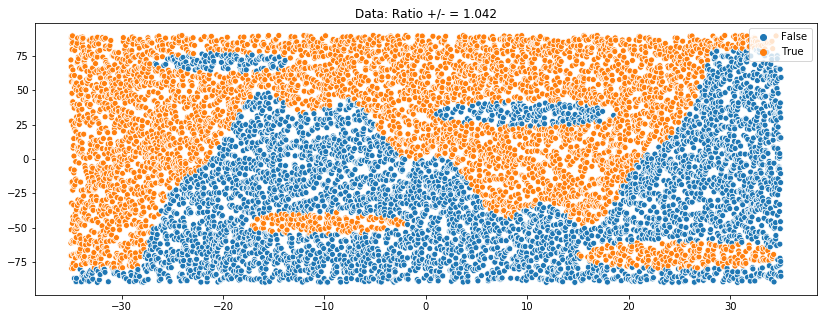

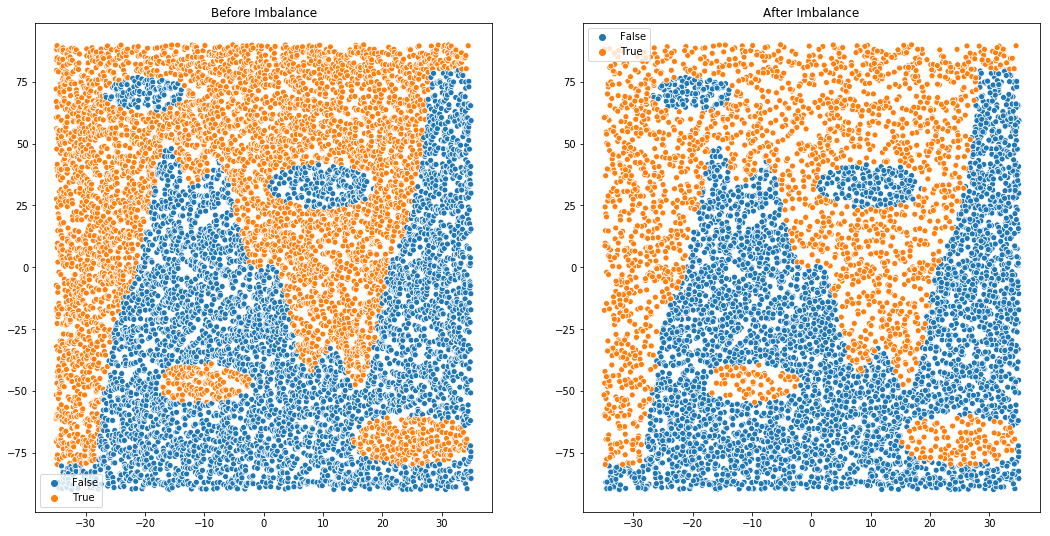

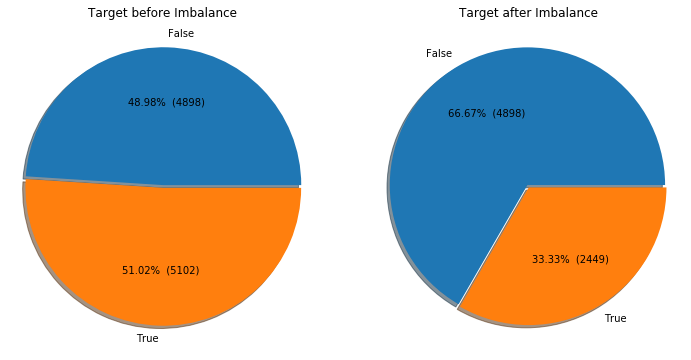


Number of Target Labels noised = 734, Noise fraction=0.100

Best Possible Metrics After Introducing Noise:
              precision    recall  f1-score   support

       False       0.90      0.95      0.93      4647
        True       0.91      0.83      0.87      2700

   micro avg       0.91      0.91      0.91      7347
   macro avg       0.91      0.89      0.90      7347
weighted avg       0.91      0.91      0.90      7347



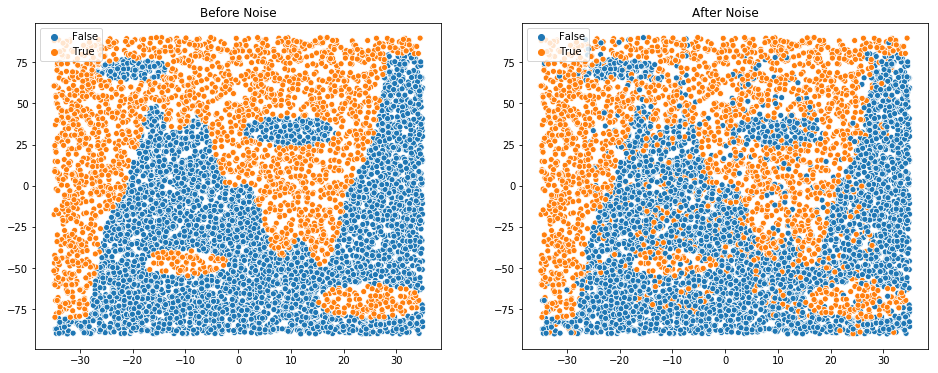

Plotting Imbalance and Noise after Oversampling


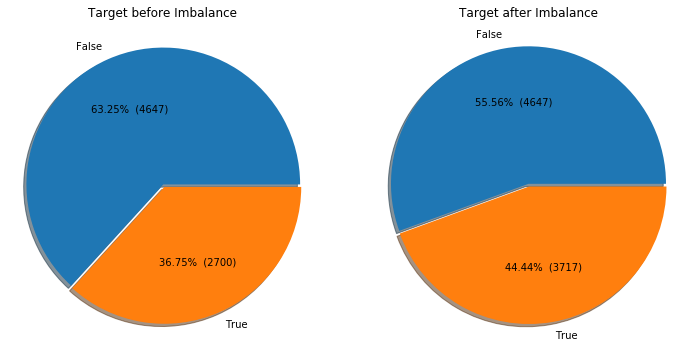

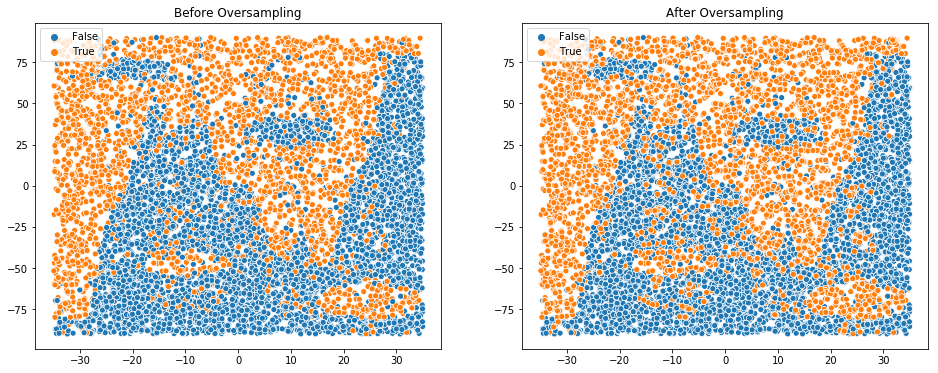

In [24]:
X,y = generate_data(10000,plot=True)
X,y = imbalance(X,y,pos_neg_frac=0.5,plot=True)
X,y = add_noise(X,y,noise_level = 0.1,noise_type = "near_decision_boundary_labels",plot=True)
X,y = oversample(X,y,pos_neg_frac=0.8,plot=True)
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3)

6.1035155e-07
5e-05
Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

      False       0.68      0.95      0.44      0.79      0.65      0.44      1280
       True       0.87      0.44      0.95      0.58      0.65      0.40      1038

avg / total       0.76      0.72      0.67      0.70      0.65      0.42      2318


Train Acc: 0.74533, Test Acc: 0.71959

Train AP: 0.74154, Test AP: 0.72066


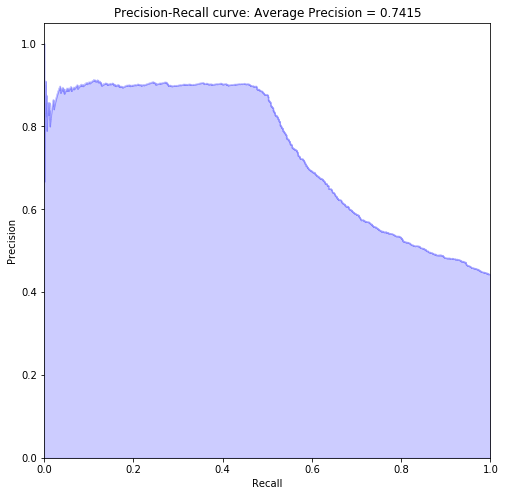

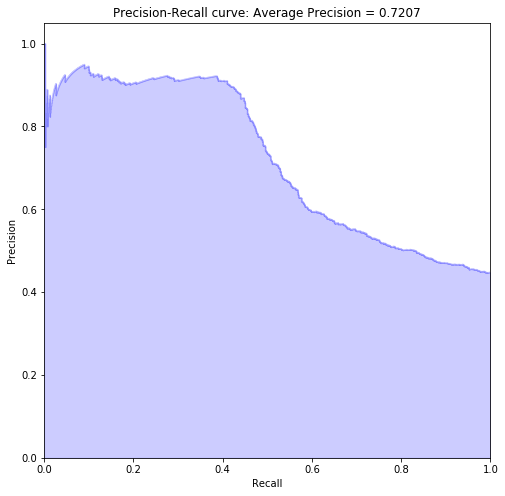


TSNE Plots of Reduced Dim classification Accuracy


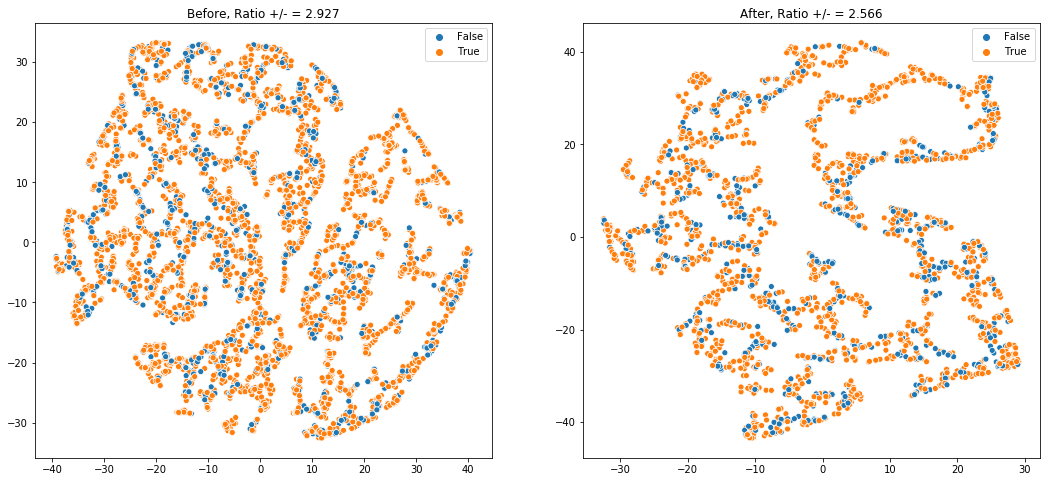

(0.7415390308846775, 0.7206551153749777)

In [14]:
network_config = [{'neurons':1024,'activation':'relu',"dropout":0.3},
                  {'neurons':1024,'activation':'relu',"dropout":0.1},
                  {'neurons':512,'activation':'relu',"dropout":0.1},
                  {'neurons':256,'activation':'selu',"dropout":0},
                  {'neurons':64,'activation':'selu',"dropout":0}]

nn = BinaryClassifierKerasDNN(network_config,lr=0.005,columns=X_train.columns)
run_classifier(nn,[average_precision_scorer],X_train,y_train,X_test,y_test,plot=True)


# Exploratory

## Noisy Labels and effect on Metrics
- We make two plots here for our data. 1st plot shows the maximum possible score given a scoring function. 2nd plot shows a model's score for different level of noise.
- We try to look at these graphs and try to answer questions like:
    - Is your model fitting noise? Variance problem?
    - Is the test score you are getting at the level of noise optimal?

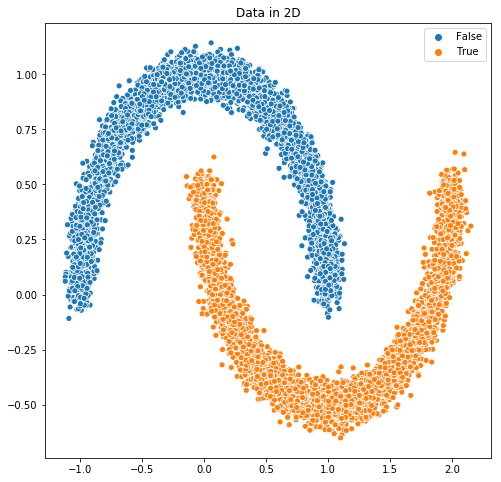

In [27]:
from sklearn.datasets import make_classification
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_moons

# X,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=[0.5,0.5])

# X,y = make_blobs(n_samples=10000, centers=2, n_features=2,random_state=17)

X,y = make_moons(10000,noise=0.05)


X = pd.DataFrame(X,columns=['x','y'])
y = pd.Series(y)


visualize_2d(X,y)

In [444]:
# we keep increasing noise and plot out what is max possible of various metrics in a graph
def build_model():
    classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=3)
    return classifier


def plot_metric_noise(X,y,scorer,build_model):
    
    perfect_scores = []
    model_scores_train = []
    model_scores_test = []
    classifier = build_model()
    X_train, X_test, y_train, y_test = split(X,y)
    model_score_no_noise = run_classifier(classifier,[scorer],X_train,y_train,X_test,y_test,plot=False)
    model_score_no_noise = model_score_no_noise[scorer.__name__]
    model_score_no_noise_train = model_score_no_noise[0]
    model_score_no_noise_test = model_score_no_noise[1]
    
    noise_levels = np.arange(0.01,0.5,0.01)
    for noise_level in noise_levels:
        
        X_res,y_res = add_noise(X,y,noise_level,plot=False)
        X_train_ns, X_test_ns, y_train_ns, y_test_ns = split(X_res,y_res)
        classifier = build_model()
        model_scores = run_classifier(classifier,[scorer],X_train_ns,y_train_ns,X_test_ns,y_test_ns,plot=False)
        model_scores = model_scores[scorer.__name__]
        model_scores_train.append(model_scores[0])
        model_scores_test.append(model_scores[1])
        perfect_scores.append(accuracy_scorer(y_test,y_test_ns,y_test_ns))
    
    plt.figure(figsize=(18,8))
    sns.lineplot(noise_levels,perfect_scores,label="Perfect Test score")
    sns.lineplot(noise_levels,model_scores_train,label="Training Score with noise")
    sns.lineplot(noise_levels,model_scores_test,label="Test Score with noise")
    sns.lineplot(noise_levels,[model_score_no_noise_train]*len(noise_levels),label="No Noise Train Score")
    sns.lineplot(noise_levels,[model_score_no_noise_test]*len(noise_levels),label="No Noise Test Score")
    plt.show()
    
    return np.array([perfect_scores,model_scores_train,model_scores_test])
        
    

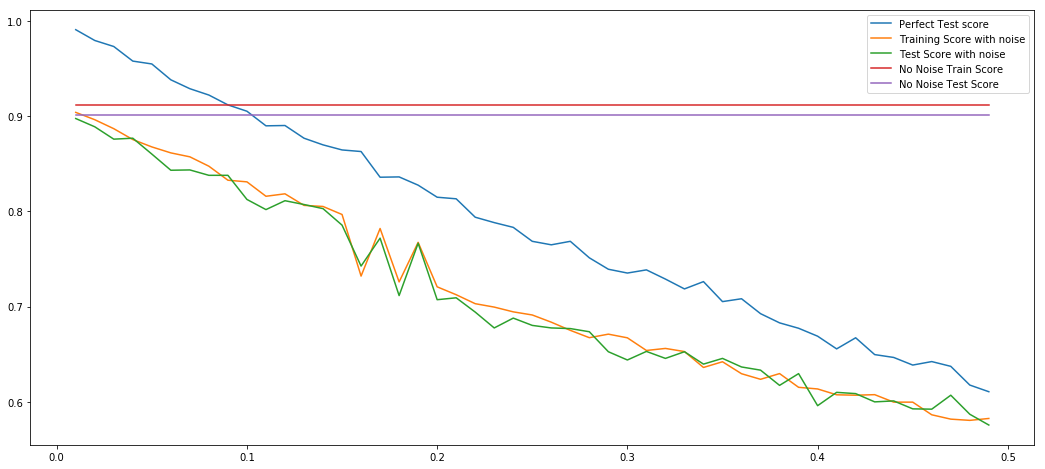

In [431]:
plot_metric_noise(X,y,scorer,build_model);

## Exercise 1: Find the Noise behaviour with your own Dataset and model

### Step 1: Load the dataset

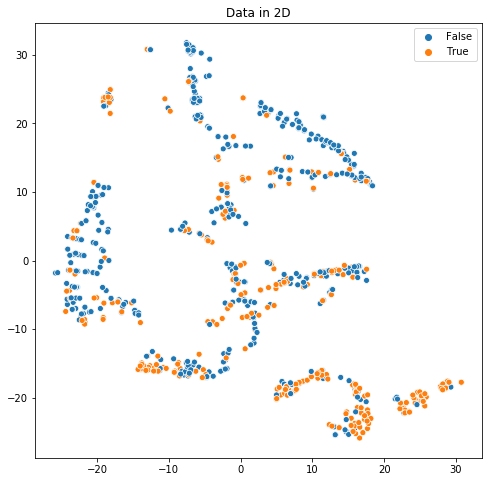

In [610]:
X = pd.read_csv("titanic.csv")
y = X['Survived']
# drop the target column from X
X['Sx'] = 0
X.loc[X['Sex']=="male",'Sx'] = 1
X = X[["Pclass","Sx","Age","Fare","SibSp"]]
X = X.fillna(X.median())

visualize_2d(X,y,algorithm="tsne")

### Step 2: Build your model
We will use Logistic Regression for this

In [28]:
def build_model():
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import make_pipeline
    classifier = make_pipeline(StandardScaler(), LogisticRegression())
    return classifier

### Step 3: Define a scorer or use one already given

In [29]:
def f1_scorer(y,y_pred,y_proba):
    from sklearn.metrics import f1_score
    return f1_score(y,y_pred)

### Step 4: Finally run the visualization

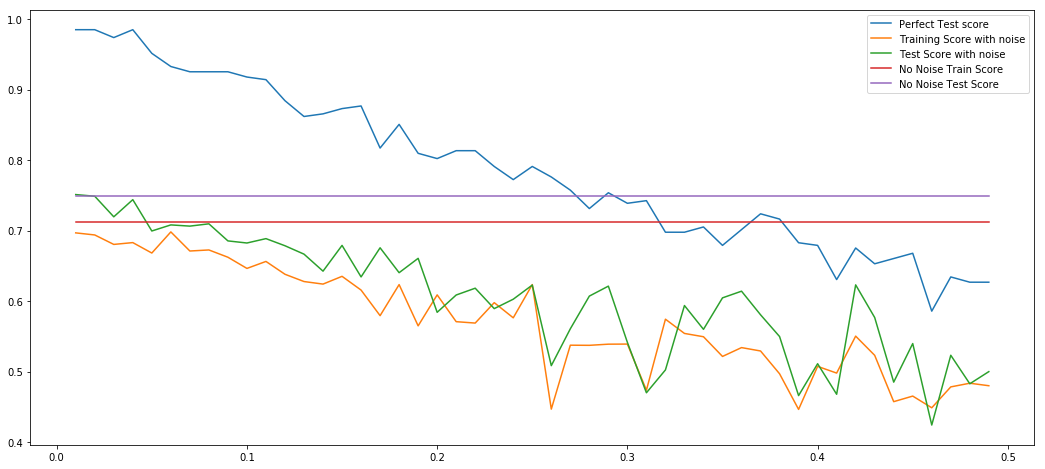

In [448]:
lr_scores = plot_metric_noise(X,y,f1_scorer,build_model)

### Step 5: Try a different Model on Same data.
- we define another `build_model` function for this.

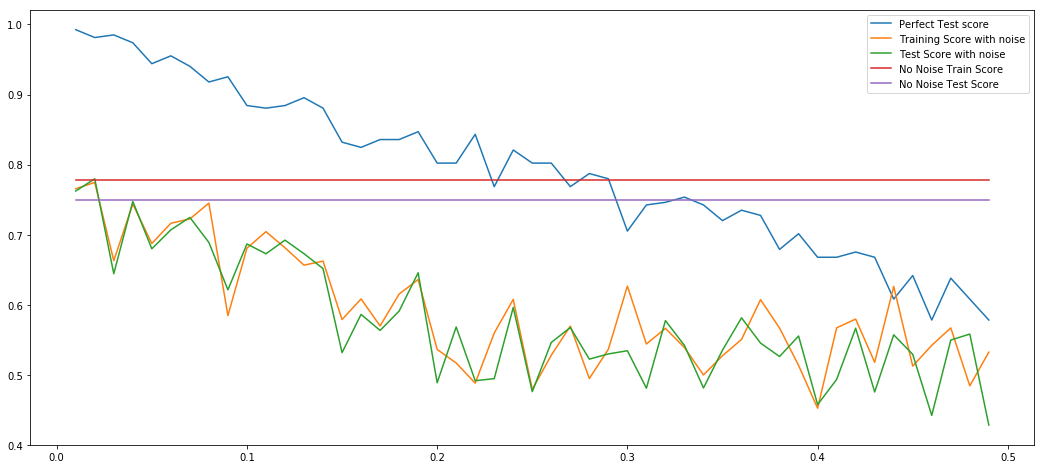

In [466]:
def build_model():
    classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                         algorithm="SAMME",
                         n_estimators=20)
    return classifier

boosted_scores = plot_metric_noise(X,y,f1_scorer,build_model)

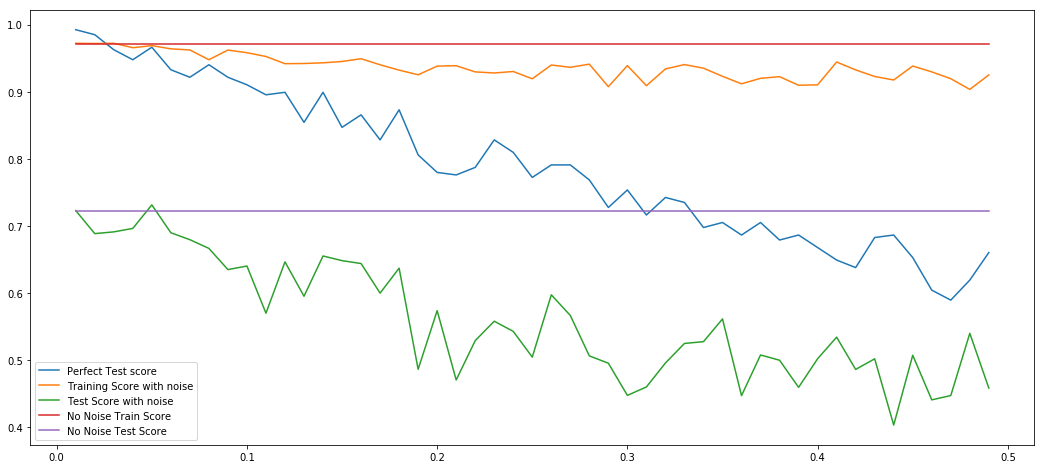

In [470]:
def build_model():
    classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                         algorithm="SAMME",
                         n_estimators=200)
    return classifier

boosted_scores_200 = plot_metric_noise(X,y,f1_scorer,build_model)

Notice something here

### Step 6: Another Classifier (DNN)

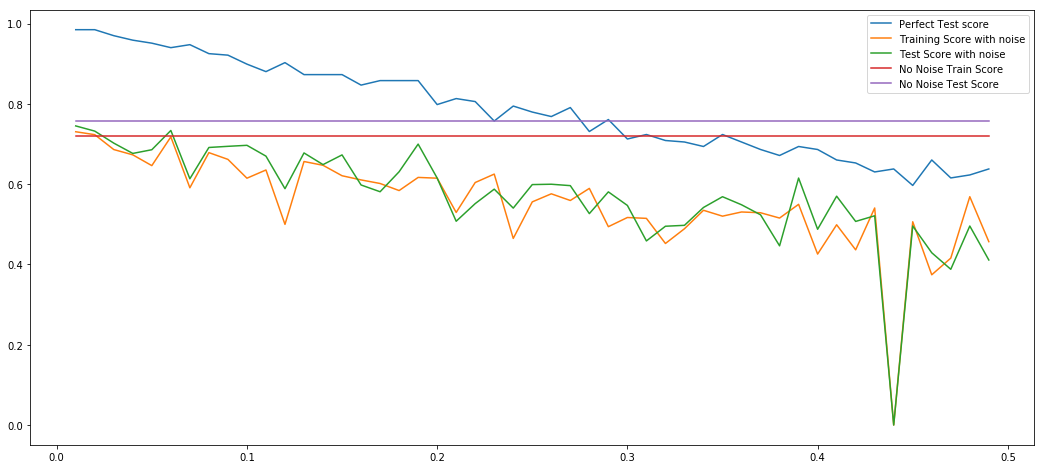

In [450]:
def build_model():
    network_config = [{'neurons':8,'activation':'relu',"dropout":0},
                     {'neurons':8,'activation':'relu',"dropout":0}]

    nn = BinaryClassifierKerasDNN(network_config,lr=0.005,columns=X.columns,plot=False)
    return nn
nn_scores = plot_metric_noise(X,y,f1_scorer,build_model)

### Compare the various classifiers and find which works better in noise?

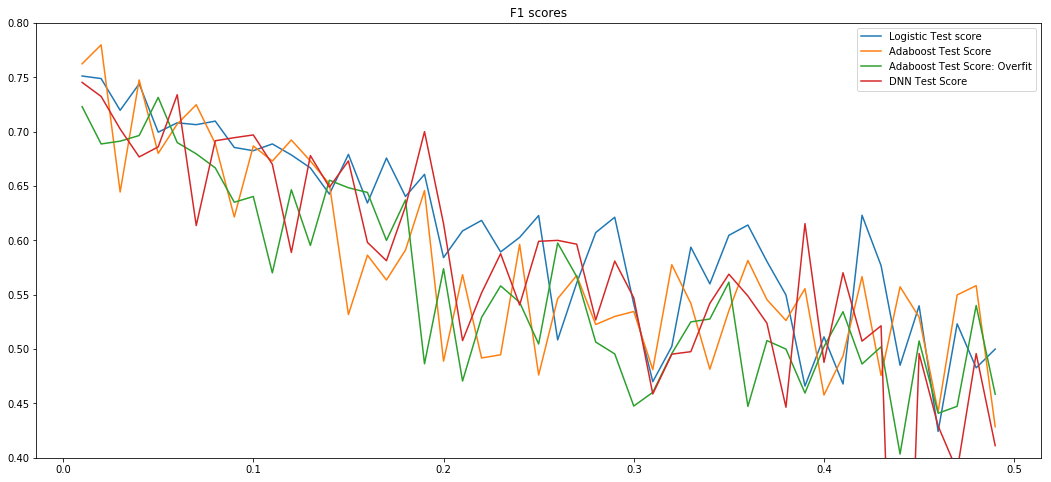

In [477]:
noise_levels = np.arange(0.01,0.5,0.01)
plt.figure(figsize=(18,8));
# sns.lineplot(noise_levels,lr_scores[0],label="Perfect Test score");
sns.lineplot(noise_levels,lr_scores[-1],label="Logistic Test score");
sns.lineplot(noise_levels,boosted_scores[-1],label="Adaboost Test Score");
sns.lineplot(noise_levels,boosted_scores_200[-1],label="Adaboost Test Score: Overfit");
sns.lineplot(noise_levels,nn_scores[-1],label="DNN Test Score");
plt.ylim((0.4,0.8))
plt.title("F1 scores")
plt.show();

Notice how the different classifiers have performances with increasing noise. Seemingly they have similar performance on all noise levels. Their performance decreases drastically as noise increases. Lets smoothen these curves a bit to see how performance decreases with noise.

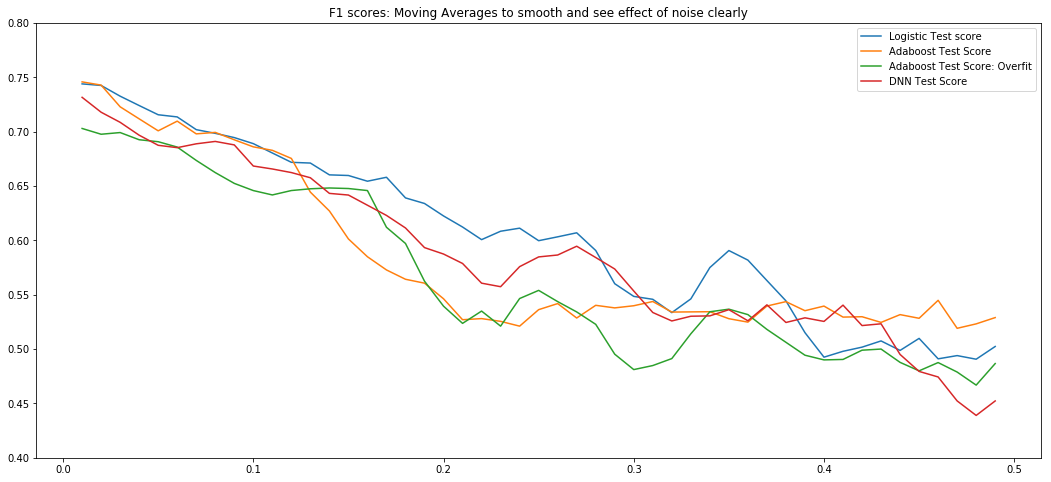

In [555]:
noise_levels = np.arange(0.01,0.5,0.01)
plt.figure(figsize=(18,8));
sns.lineplot(noise_levels,smoothen(lr_scores[-1]),label="Logistic Test score");
sns.lineplot(noise_levels,smoothen(boosted_scores[-1]),label="Adaboost Test Score");
sns.lineplot(noise_levels,smoothen(boosted_scores_200[-1]),label="Adaboost Test Score: Overfit");
sns.lineplot(noise_levels,smoothen(nn_scores[-1]),label="DNN Test Score");
plt.ylim((0.4,0.8))
plt.title("F1 scores: Moving Averages to smooth and see effect of noise clearly")
plt.show();

In [ ]:
# Your code here.

## Choose Correct Metric for Imbalance

In [389]:
def build_model():
    classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                         algorithm="SAMME",
                         n_estimators=4)
    return classifier


def imbalance_impact(build_model,scorers,data_generator):
    X,y = data_generator()
    scores = []
    for imb in list(reversed(np.arange(0.05,1,0.05))):
        X_res,y_res = imbalance(X,y,pos_neg_frac=imb)
        X_train, X_test, y_train, y_test = split(X_res,y_res)
        classifier = build_model()
        scores.append(run_classifier(classifier,scorers,X_train,y_train,X_test,y_test,plot=False))
        
    score_dict = {}
    for score in scores:
        for scorer,values in score.items():
            if scorer in score_dict:
                score_dict[scorer].append(values)
            else:
                score_dict[scorer] = [values]
                
    plt.figure(figsize=(16,6))
    ax = plt.axes()
    x = list(map(lambda x:"%.2f"%x,reversed(np.arange(0.05,1,0.05))))
    for score,values in score_dict.items():
        values = np.array(values)
        # plt.plot(values[:,0],label="%s_train"%(score))
        plt.plot(values[:,1],label="%s_test"%(score))
    plt.legend()
    plt.xlabel("Increasing Imbalance (Ratio of +ve to -ve class) --> ")
    plt.ylabel("Metric (Higher is better) --> ")
    ax.xaxis.set_ticks(list(range(len(x))))
    ax.xaxis.set_ticklabels(x)
    plt.show()
                
    return score_dict,scores
        

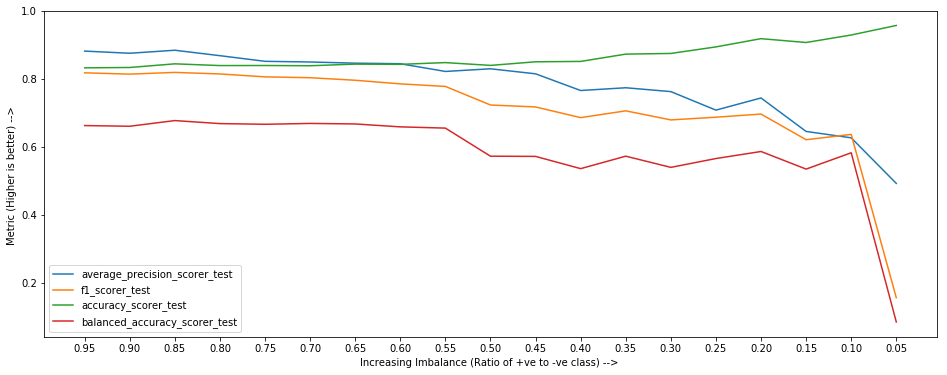

In [390]:

score_dict,scores = imbalance_impact(build_model,[average_precision_scorer,f1_scorer,accuracy_scorer,balanced_accuracy_scorer],generate_data)


## Exercise 2: Use your own Data, scorer, model and check its behavior for Imbalance
- We will use Random Forest ALgorithm For this.
- For scorer we will define a new scorer to find roc_auc_score of our model.
- We will use a different dataset here.
- We will compare it to f1 and accuracy_scorers already provided in notebook.

In [292]:
# 1st lets build the model function
# define a build_model function which returns your desired model, each time a new instance 
def build_model():
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier(n_estimators=10, max_depth=5)
    return classifier

In [293]:
# Next we define our new roc_auc_score scorer, 
# note our scorers have 3 params for genericness: true_labels,predicted_labels,predicted_probabilities

def roc_auc_scorer(y,y_pred,y_proba):
    from sklearn.metrics import roc_auc_score
    return roc_auc_score(y,y_proba)

In [391]:
# Lets use the titanic dataset from kaggle
# I have downloaded it and put it in the working dir. You can do the same for your dataset

# define a data_generator to return X,y

def data_generator():
    X = pd.read_csv("titanic.csv")
    y = X['Survived']
    # drop the target column from X
    df_utils.drop_columns_safely(X,['Survived'],inplace=True)
    X['Sx'] = 0
    X.loc[X['Sex']=="male",'Sx'] = 1
    X = X[["Pclass","Sx","Age","Fare","SibSp"]]
    X = X.fillna(X.median())
    return X,y

WARN: Data is already imbalanced! Imbalance = 0.6230 Try oversampling
WARN: Data is already imbalanced! Imbalance = 0.6230 Try oversampling
WARN: Data is already imbalanced! Imbalance = 0.6230 Try oversampling
WARN: Data is already imbalanced! Imbalance = 0.6230 Try oversampling
WARN: Data is already imbalanced! Imbalance = 0.6230 Try oversampling
WARN: Data is already imbalanced! Imbalance = 0.6230 Try oversampling
WARN: Data is already imbalanced! Imbalance = 0.6230 Try oversampling


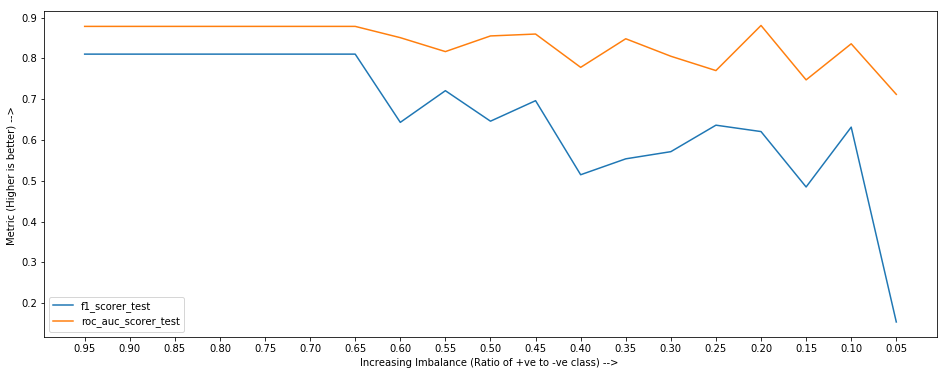

In [392]:
# Now we are going to run our function to plot effects of Imbalance

score_dict,scores = imbalance_impact(build_model,[f1_scorer,roc_auc_scorer],data_generator)



## Generating Data using Standard Scikit Functions

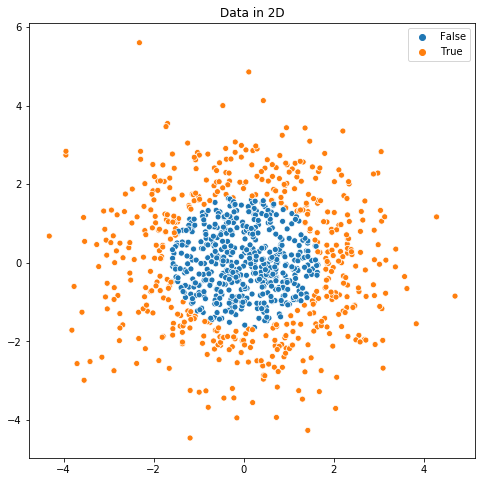

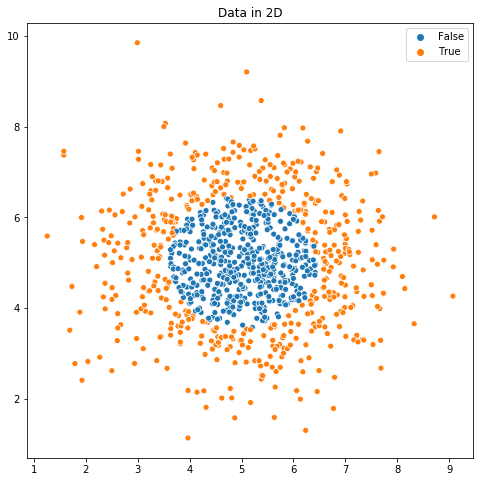

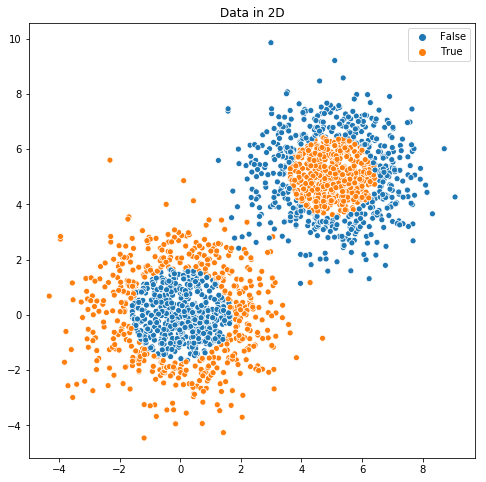

In [611]:
from sklearn.datasets import make_gaussian_quantiles


# Construct dataset
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=1000, n_features=2,
                                 n_classes=2, random_state=1)

X1 = pd.DataFrame(X1,columns=['x','y'])
y1 = pd.Series(y1)
visualize_2d(X1,y1)
X2, y2 = make_gaussian_quantiles(mean=(5, 5), cov=1.5,
                                 n_samples=1000, n_features=2,
                                 n_classes=2, random_state=1)

X2 = pd.DataFrame(X2,columns=['x','y'])
y2 = pd.Series(y2)
visualize_2d(X2,y2)


X = pd.DataFrame(np.concatenate((X1, X2)),columns=['x','y'])
y = pd.Series(np.concatenate((y1, - y2 + 1)))

visualize_2d(X,y)

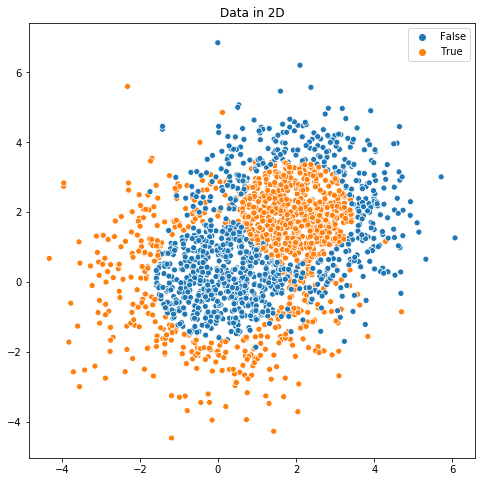

In [613]:
from sklearn.datasets import make_gaussian_quantiles


# Construct dataset
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=1000, n_features=2,
                                 n_classes=2, random_state=1)


X2, y2 = make_gaussian_quantiles(mean=(2, 2), cov=1.5,
                                 n_samples=1000, n_features=2,
                                 n_classes=2, random_state=1)



X = pd.DataFrame(np.concatenate((X1, X2)),columns=['x','y'])
# X['x'] = 5*X['x']
y = pd.Series(np.concatenate((y1, - y2 + 1)))

visualize_2d(X,y)

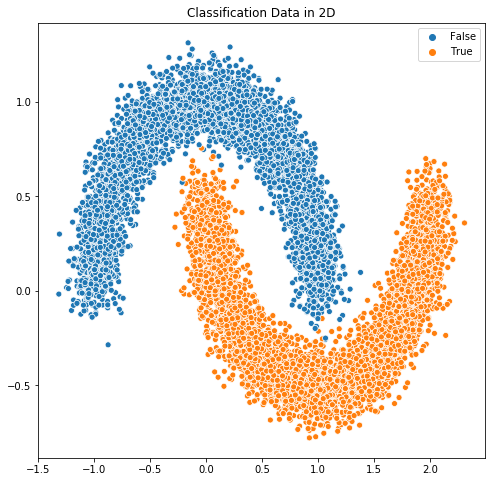

In [374]:
# Moons
from sklearn.datasets import make_moons

X,y = make_moons(10000,noise=0.1)
X = pd.DataFrame(X,columns=['x','y'])
y = pd.Series(y)

visualize_2d(X,y)

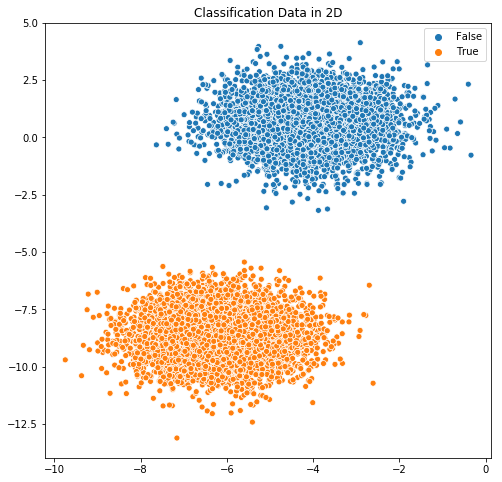

In [373]:
X,y = make_blobs(n_samples=10000, centers=2, n_features=2,random_state=17)

X = pd.DataFrame(X,columns=['x','y'])
y = pd.Series(y)


visualize_2d(X,y)

In [ ]:
X,y = make_blobs(n_samples=1000, centers=2, n_features=3,random_state=17)

X = pd.DataFrame(X,columns=['x','y','z'])
y = pd.Series(y)
    
visualize_3d(X,y)


In [ ]:
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=1000, n_features=3,
                                 n_classes=2, random_state=1)


X2, y2 = make_gaussian_quantiles(mean=(3,3,3), cov=1.5,
                                 n_samples=1000, n_features=3,
                                 n_classes=2, random_state=1)



X = pd.DataFrame(np.concatenate((X1, X2)),columns=['x','y','z'])
y = pd.Series(np.concatenate((y1, - y2 + 1)))

visualize_3d(X,y)

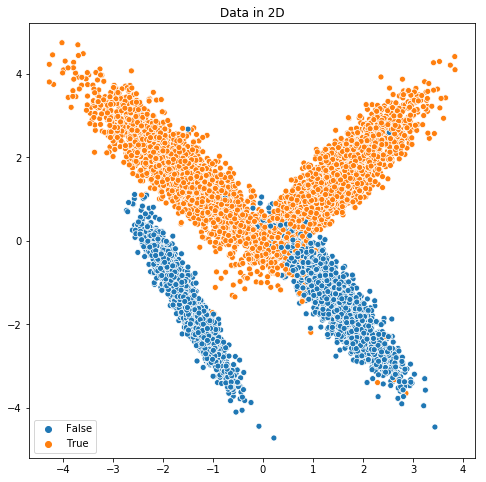

In [616]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=10000, n_features=2, n_informative=2, 
                    n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2,
                          class_sep=1.5,
                   flip_y=0.01,weights=[0.5,0.5])

X = pd.DataFrame(X,columns=['x','y'])
y = pd.Series(y)

visualize_2d(X,y)



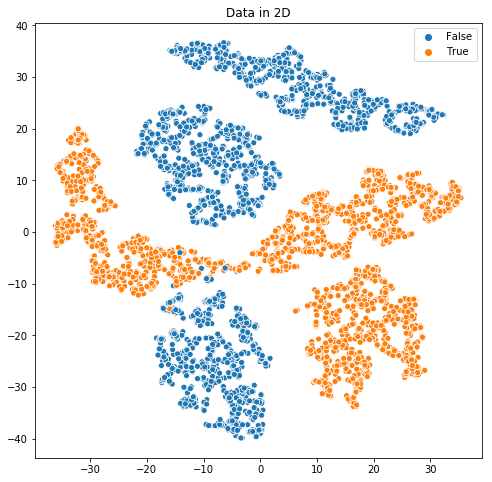

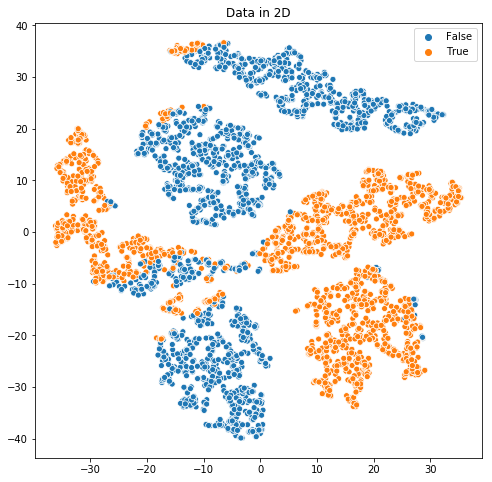

In [257]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=4000, n_features=3, n_informative=3, 
                    n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=3,class_sep=2,
                   flip_y=0.0,weights=[0.5,0.5])

X = pd.DataFrame(X,columns=['x','y','z'])
y = pd.Series(y)

visualize_2d(X,y,algorithm="tsne")

X,y = add_noise(X,y,noise_level = 0.4,noise_type = "near_decision_boundary_labels",plot=False)

visualize_2d(X,y,algorithm="tsne")

In [ ]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=10000, n_features=3, n_informative=3, 
                    n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=3,class_sep=2,
                   flip_y=0.0,weights=[0.5,0.5])

X = pd.DataFrame(X,columns=['x','y','z'])
y = pd.Series(y)

visualize_3d(X,y)


## Imbalance and Noise Effects on Metrics
We will provide a utility here to make a heatmap which tells the effect of increasing noise and imbalance on our dataset with a scoring function we provide. We provide ability to use 4 classifiers at the same time to show the ability of different classifiers.

Now we know from experience that imbalanced datasets are better measures with average precision and f1 score. So we will use these 2 metrics in our examples.

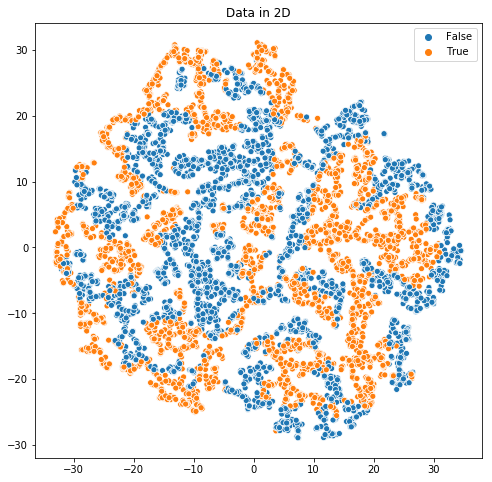

In [362]:


from sklearn.datasets import make_gaussian_quantiles



X1, y1 = make_gaussian_quantiles(cov=3.,
                                 n_samples=4000, n_features=3,
                                 n_classes=2, random_state=1)

X2, y2 = make_gaussian_quantiles(mean=(5, 5, 5), cov=3,
                                 n_samples=3000, n_features=3,
                                 n_classes=2, random_state=1)




X = pd.DataFrame(np.concatenate((X1, X2)),columns=['x','y','z'])
y = pd.Series(np.concatenate((y1, - y2 + 1)))

visualize_2d(X,y)

In [363]:





def plot_heatmap(X,y,scorer,
                build_models):
    X_org,y_org = X.copy(deep=True),y.copy(deep=True)
    imbalances = [0.05, 0.1, 0.2, 0.5, 1]
    noise_levels = [0,0.01,0.02,0.05,0.1]
    
    num_models = len(build_models)
    num_rows = int(np.ceil(num_models/2))
    fig, axes = plt.subplots(num_rows,2,figsize=(18,6*num_rows))
    axes = list(more_itertools.flatten(axes))
    model_scores = []
    for i,name in enumerate(build_models.keys()):
        scores = []
        build_model = build_models[name]
        for imbalance_ratio in imbalances:
            sc = []
            for noise_level in noise_levels:
                X,y = imbalance(X_org,y_org,pos_neg_frac=imbalance_ratio,plot=False)
                X,y = add_noise(X,y,noise_level = noise_level,noise_type = "randomize_labels",plot=False)
                X_train, X_test, y_train, y_test = split(X,y)
                scale_pos_weight = max(int(np.sum(~y_train)/np.sum(y_train)),1)
                
                classifier = build_model(scale_pos_weight=scale_pos_weight)
                score = run_classifier(classifier,[scorer],X_train,y_train,X_test,y_test,plot=False)
                test_score = score[scorer.__name__][-1]
                sc.append(test_score)
            scores.append(sc)
        scores = np.array(scores)
        model_scores.append(scores)
    model_scores = np.array(model_scores)
    vmin = model_scores.min()
    vmax = model_scores.max()
    for i,name in enumerate(build_models.keys()):
        ax = axes[i]
        scores = model_scores[i]
        classifier = build_model()
        # type(classifier).__name__
        ax.set_title("%s Heatmap for %s"%(scorer.__name__,name));
        sns.heatmap(data=scores,annot = True,fmt = '.2f',cmap="Reds_r",robust=True,
                    vmin=vmin, vmax=vmax,
                    ax=ax);
        xticks = ["%.2f"%x for x in noise_levels]
        ax.set_xticklabels(xticks, minor=False, rotation=0)
        yticks = ["%.2f"%x for x in imbalances]
        ax.set_yticklabels(yticks, minor=False, rotation=0)
        ax.set_xlabel("Noise Level --> Increasing")
        ax.set_ylabel("Imbalance --> Increasing")
    plt.show();
            
            

    


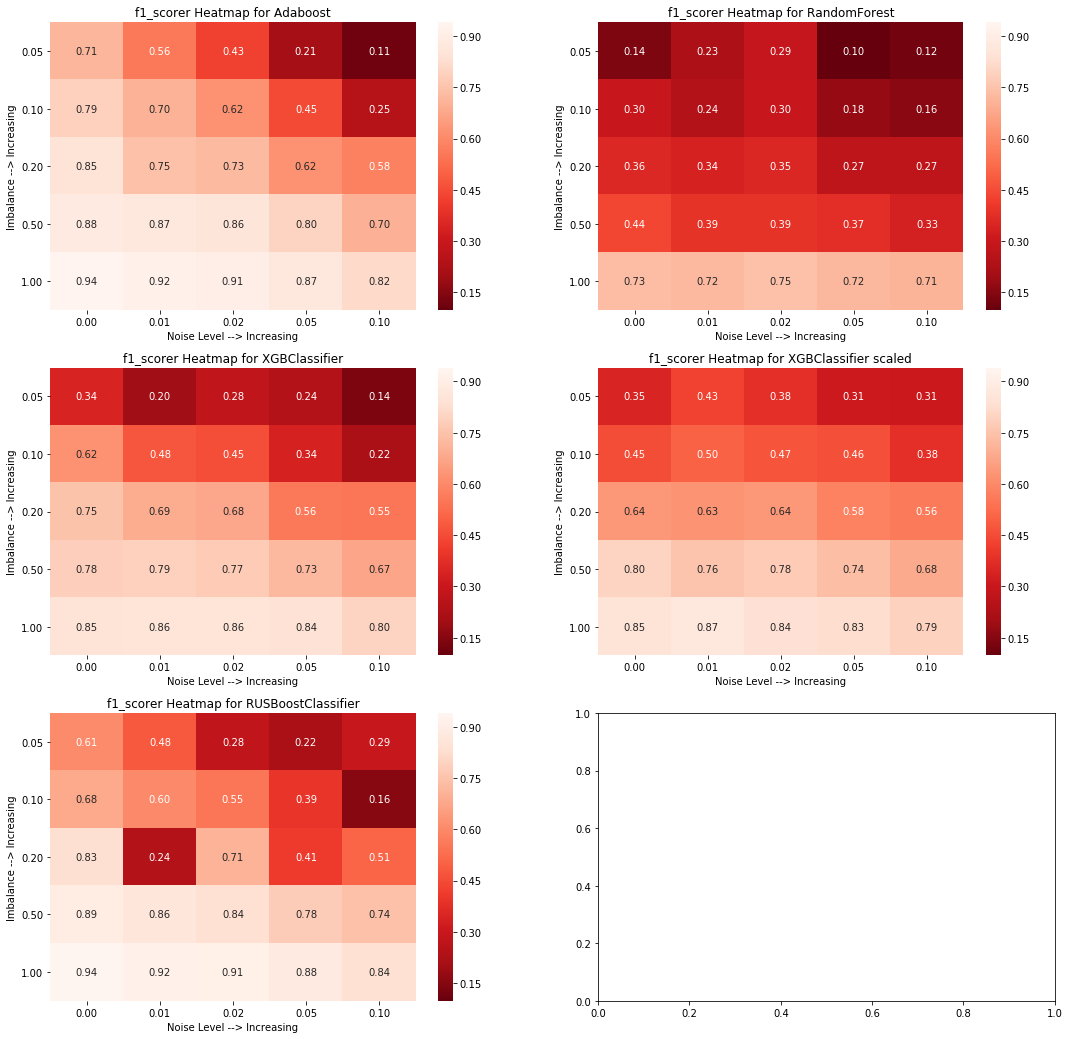

In [364]:
def build_model_xgb(scale_pos_weight=None):
    classifier = XGBClassifier(n_estimators=100,max_depth=3)
    return classifier

def build_model_adb(scale_pos_weight=None):
    classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                         algorithm="SAMME",
                         n_estimators=100)
    return classifier

def build_model_rf(scale_pos_weight=None):
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier(n_estimators=100, max_depth=3)
    return classifier


def build_model_rb(scale_pos_weight=None):
    classifier = RUSBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),n_estimators=100, 
                                    learning_rate=0.1, algorithm='SAMME.R', 
                                    sampling_strategy='auto', replacement=False)
    return classifier

def build_model_xgb_scaled(scale_pos_weight=1):
    classifier = XGBClassifier(n_estimators=100,max_depth=3,scale_pos_weight=scale_pos_weight)
    return classifier





plot_heatmap(X,y,f1_scorer,
             {"Adaboost":build_model_adb,
              "RandomForest":build_model_rf,
              "XGBClassifier":build_model_xgb,
              "XGBClassifier scaled":build_model_xgb_scaled,
              "RUSBoostClassifier":build_model_rb})


Notice how RUSBoostClassifier outperforms XGBoost in some cases.

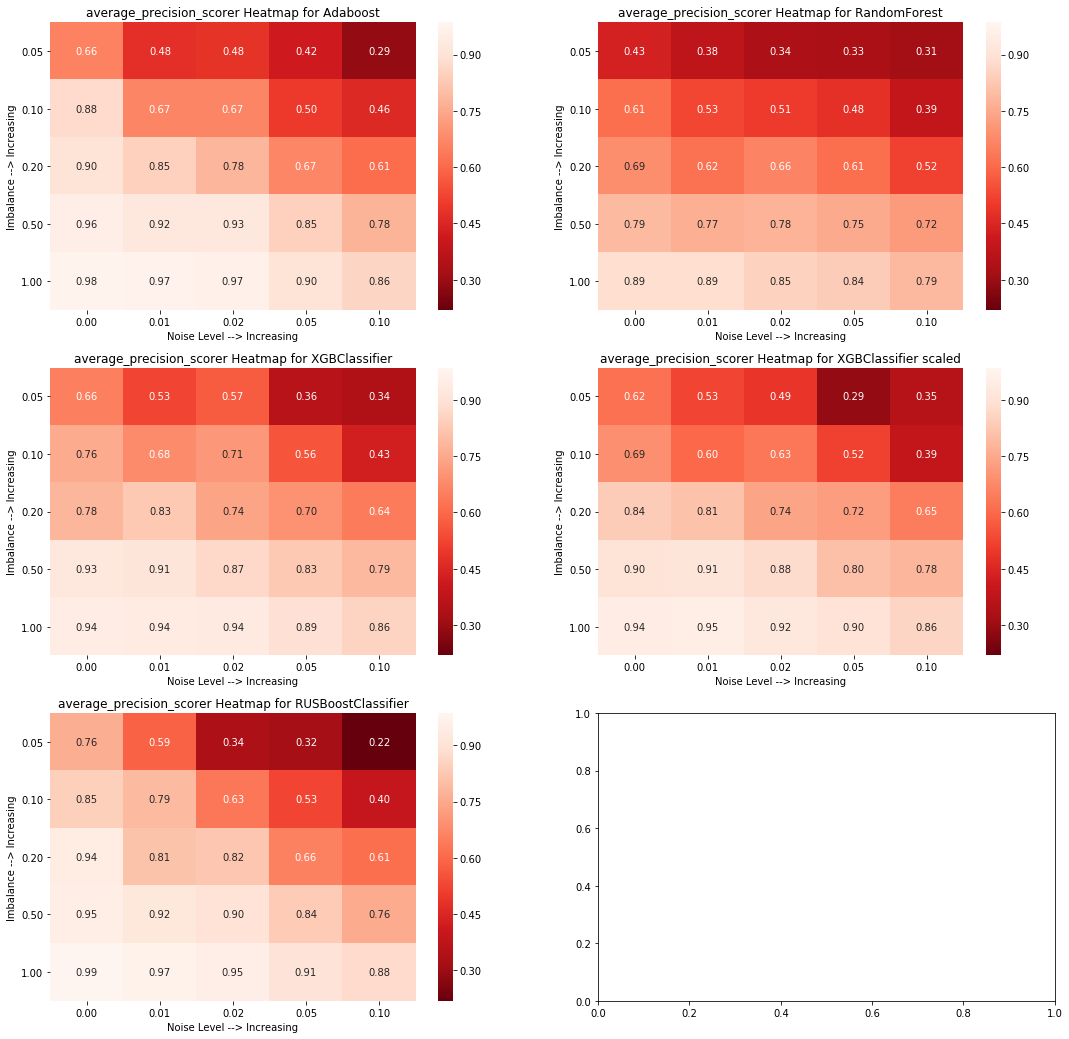

In [365]:
plot_heatmap(X,y,average_precision_scorer,
             {"Adaboost":build_model_adb,
              "RandomForest":build_model_rf,
              "XGBClassifier":build_model_xgb,
              "XGBClassifier scaled":build_model_xgb_scaled,
              "RUSBoostClassifier":build_model_rb})


### Lets define a new metric precision@recall=75 and try this

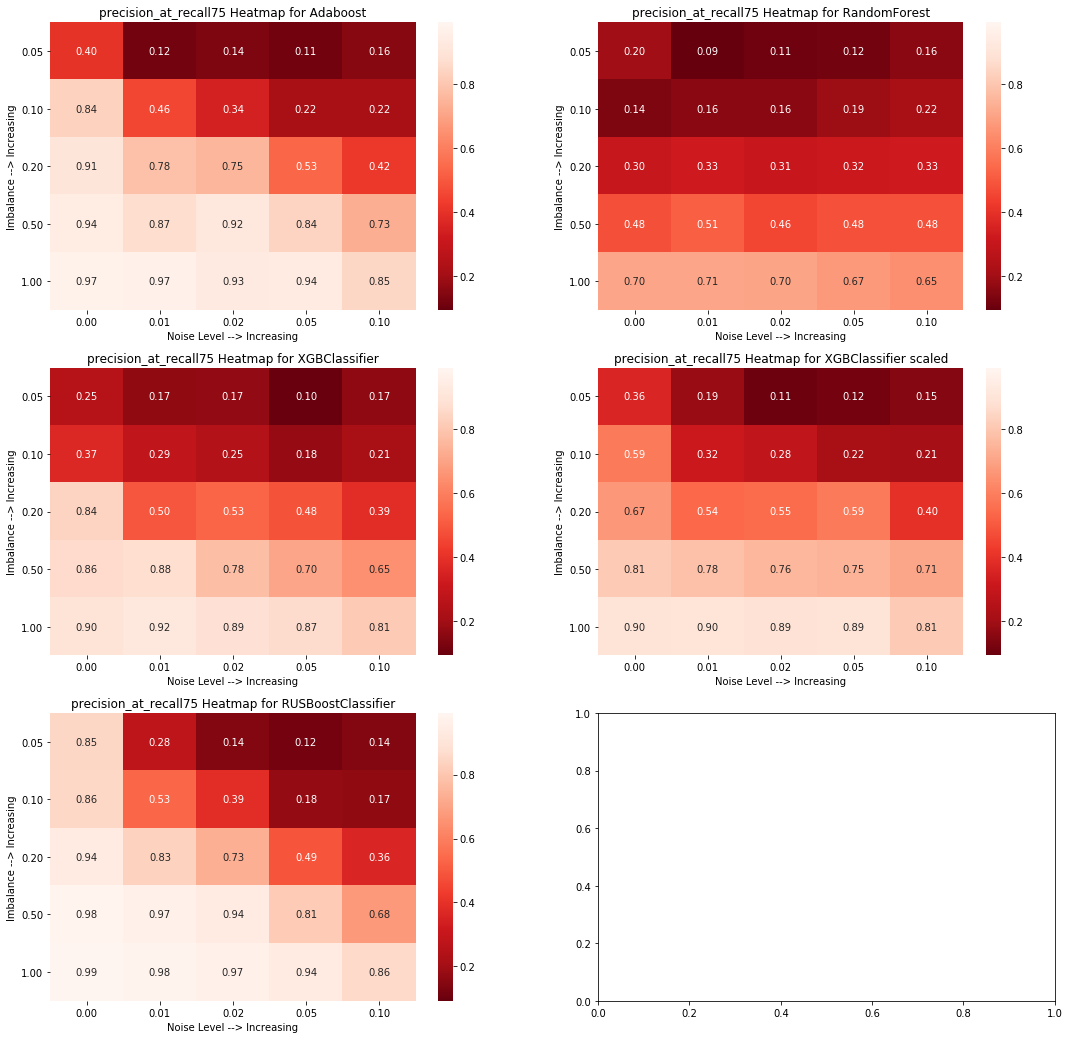

In [366]:
def precision_at_recall75(y,y_pred,y_score):
    from sklearn.metrics import precision_recall_curve
    precision, recall, _ = precision_recall_curve(y, y_score)
    return precision[recall>0.75][-1]

plot_heatmap(X,y,precision_at_recall75,
             {"Adaboost":build_model_adb,
              "RandomForest":build_model_rf,
              "XGBClassifier":build_model_xgb,
              "XGBClassifier scaled":build_model_xgb_scaled,
              "RUSBoostClassifier":build_model_rb})


**Notice**

With high number of datapoints and low noise, RUSBOOST can give better results than XGBoost for imbalanced problems

### Lets try on titanic Dataset with the new metric precision@recall=75

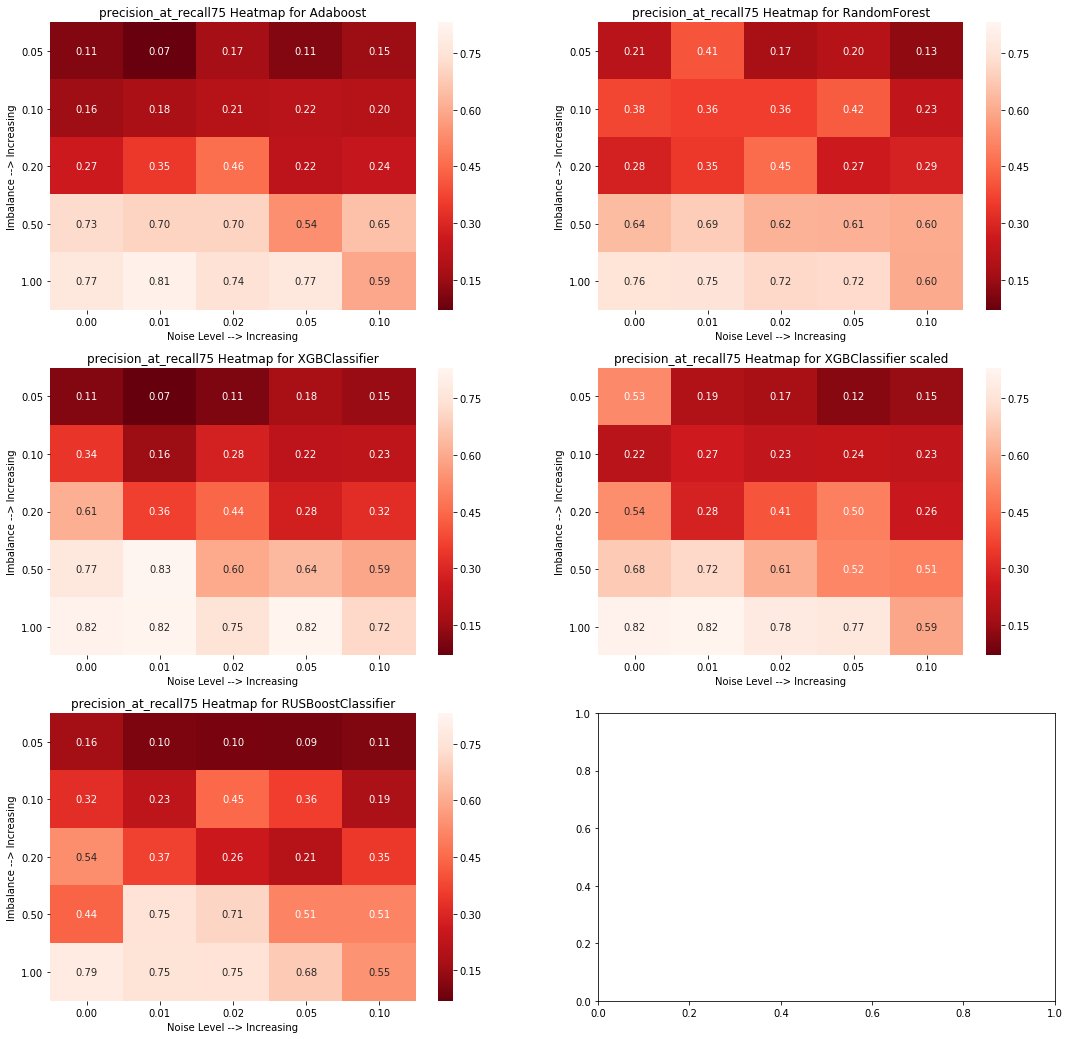

In [367]:
# Your Data here
X = pd.read_csv("titanic.csv")
y = X['Survived']
# drop the target column from X
X['Sx'] = 0
X.loc[X['Sex']=="male",'Sx'] = 1
X = X[["Pclass","Sx","Age","Fare","SibSp"]]
X = X.fillna(X.median())




plot_heatmap(X,y,precision_at_recall75,
             {"Adaboost":build_model_adb,
              "RandomForest":build_model_rf,
              "XGBClassifier":build_model_xgb,
              "XGBClassifier scaled":build_model_xgb_scaled,
              "RUSBoostClassifier":build_model_rb})




## Effect of oversampling strategies on Noisy Imbalanced Labels
Oversampling to reduce imbalance in noisy Labels could result in more noise in our Labels. In this section we will look at different oversampling strategies in presence of noise using 2-D Data.

### Get your Dataset
- Your Predictors should be Dataframe
- Your Labels should be Pandas Series
- See Below for Example
- You can use datasets with more than 2 columns as well. You won't be visualizing them though.

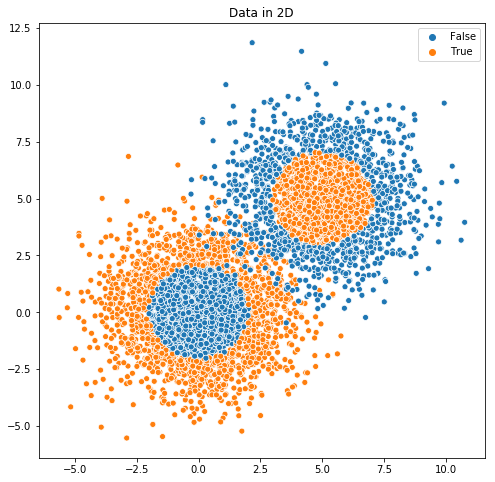

In [41]:
from sklearn.datasets import make_gaussian_quantiles



X1, y1 = make_gaussian_quantiles(cov=3.,
                                 n_samples=3000, n_features=2,
                                 n_classes=2, random_state=1)

X2, y2 = make_gaussian_quantiles(mean=(5, 5), cov=3,
                                 n_samples=2000, n_features=2,
                                 n_classes=2, random_state=1)




X = pd.DataFrame(np.concatenate((X1, X2)),columns=['x','y'])
y = pd.Series(np.concatenate((y1, - y2 + 1)))

visualize_2d(X,y)

### Making your Model
- define your model builder function here, this function will return a new instance of Model when it's called.
- name your function as `build_model` since we have hard-coded that name later on



In [45]:
def build_model():
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import make_pipeline
    classifier = make_pipeline(StandardScaler(), LogisticRegression())
    return classifier

def build_model():
    classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                         algorithm="SAMME",
                         n_estimators=20)
    return classifier

def build_model():
    classifier = XGBClassifier(max_depth=6,n_estimators=200)
    return classifier


# def build_model():
#     from sklearn.ensemble import RandomForestClassifier
#     classifier = RandomForestClassifier(n_estimators=10, max_depth=5)
#     return classifier


### Introducing Imbalance, Noise and then oversampling.
- Note here we will Introduce Imbalance and Noise on Full Dataset.
- Oversampling will be done only on Training Set since during actual scenario you can't change your Test Set.

In [46]:

from ipywidgets import interact, interactive, fixed, interact_manual

_ = '''
@interact(X=fixed(X),y=fixed(y),scorers=fixed([f1_scorer,accuracy_scorer,balanced_accuracy_scorer,average_precision_scorer]),
         imbalance_ratio=(0.05, 1, 0.05),noise_type=["data","randomize_labels","near_decision_boundary_labels"],
        noise_level=(0.0, 0.5, 0.01),oversample_method=[None,"smote","adasyn","randomoversampler","smoteenn","smotetomek"],
                                           oversample_ratio=(0.1,1,0.1),
                                           test_size=(0.05,0.5,0.05))
'''
def model_with_imbalance_noise_oversampling(X,y,scorers,build_model,imbalance_ratio=1,
                                            noise_type="randomize_labels",
                                           noise_level=0.01,
                                            oversample_method=None,
                                           oversample_ratio=1,
                                           test_size=0.2):
    
    classifier = build_model()
    X_org,y_org = X.copy(deep=True),y.copy(deep=True)
    X,y = imbalance(X,y,pos_neg_frac=imbalance_ratio,plot=False)
    X,y = add_noise(X,y,noise_level = noise_level,noise_type = noise_type,plot=False)
    # We do Train Test split before oversampling.
    
    X_train, X_test, y_train, y_test = split(X,y,test_size=test_size)
    
    X_train,y_train = oversample(X_train,y_train,pos_neg_frac=oversample_ratio,method=oversample_method,plot=False)
    
    ## 
    visualize_overall_train_test_data(X_org,y_org,X_train,y_train,X_test,y_test)
    ## 
    return run_classifier(classifier,scorers,X_train,y_train,X_test,y_test,plot=True,plot_data=False,plot_results=True)



In [47]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import HBox, Label

style = {'description_width': 'initial','widget_width': '400px'}
imbalance_ratio = widgets.FloatSlider(value=1,min=0.05, max=1, step=0.05,description='Imbalance Ratio',style = style)
noise_level = widgets.FloatSlider(value=0,min=0.0, max=0.5, step=0.01,description='Noise Level',style = style)
oversample_ratio = widgets.FloatSlider(value=1,min=0.1,max=1,step=0.1,description='Oversample Ratio',style = style)
test_size = widgets.FloatSlider(value=0.2,min=0.05,max=0.5,step=0.05,description='Test Size',style = style)
noise_type = widgets.Dropdown(
    options=["data","randomize_labels","near_decision_boundary_labels"],
    value="randomize_labels",
    description='Noise Type',
    disabled=False,
    style = style
)
oversample_method = widgets.Dropdown(
    options=[None,"smote","adasyn","randomoversampler","smoteenn","smotetomek"],
    value=None,
    description='Oversampling Method',
    disabled=False,
    style = style
)

hbstyle = {'description_width': 'initial','widget_width': '900px'}
ui = widgets.VBox([widgets.HBox([imbalance_ratio,test_size],style = hbstyle),
                  widgets.HBox([noise_type,noise_level],style = hbstyle),
                  widgets.HBox([oversample_method,oversample_ratio],style = hbstyle)],
                 style = hbstyle)

out = widgets.interactive_output(model_with_imbalance_noise_oversampling, {'imbalance_ratio': imbalance_ratio, 'noise_type': noise_type, 'noise_level': noise_level,
                                     "oversample_method":oversample_method,"oversample_ratio":oversample_ratio,"test_size":test_size,
                                     'X':fixed(X),'y':fixed(y),"build_model":fixed(build_model),
                                    "scorers":fixed([f1_scorer,accuracy_scorer,balanced_accuracy_scorer,average_precision_scorer])})

display(ui, out)


Output()

## Exercise 4: Use your Data to see effects of Oversampling on Noisy Imbalanced Labels

In [642]:
# Your Data here
X = pd.read_csv("titanic.csv")
y = X['Survived']
# drop the target column from X
X['Sx'] = 0
X.loc[X['Sex']=="male",'Sx'] = 1
X = X[["Pclass","Sx","Age","Fare","SibSp"]]
X = X.fillna(X.median())

In [645]:
# Your Model here
def build_model():
    classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                         algorithm="SAMME",
                         n_estimators=50)
    return classifier

In [646]:
# This code is pasted from 5.7.3 for adding interactivity

from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import HBox, Label

style = {'description_width': 'initial','widget_width': '400px'}

imbalance_ratio = widgets.FloatSlider(value=1,min=0.05, max=1, step=0.05,description='Imbalance Ratio',style = style)
noise_level = widgets.FloatSlider(value=0,min=0.0, max=0.5, step=0.01,description='Noise Level',style = style)
oversample_ratio = widgets.FloatSlider(value=1,min=0.1,max=1,step=0.1,description='Oversample Ratio',style = style)
test_size = widgets.FloatSlider(value=0.2,min=0.05,max=0.5,step=0.05,description='Test Size',style = style)
noise_type = widgets.Dropdown(
    options=["data","randomize_labels","near_decision_boundary_labels"],
    value="randomize_labels",
    description='Noise Type',
    disabled=False,
    style = style
)
oversample_method = widgets.Dropdown(
    options=[None,"smote","adasyn","randomoversampler","smoteenn","smotetomek"],
    value=None,
    description='Oversampling Method',
    disabled=False,
    style = style
)

hbstyle = {'description_width': 'initial','widget_width': '900px'}
ui = widgets.VBox([widgets.HBox([imbalance_ratio,test_size],style = hbstyle),
                  widgets.HBox([noise_type,noise_level],style = hbstyle),
                  widgets.HBox([oversample_method,oversample_ratio],style = hbstyle)],
                 style = hbstyle)

out = widgets.interactive_output(model_with_imbalance_noise_oversampling, {'imbalance_ratio': imbalance_ratio, 'noise_type': noise_type, 'noise_level': noise_level,
                                     "oversample_method":oversample_method,"oversample_ratio":oversample_ratio,"test_size":test_size,
                                     'X':fixed(X),'y':fixed(y),"build_model":fixed(build_model),
                                    "scorers":fixed([f1_scorer,accuracy_scorer,balanced_accuracy_scorer,average_precision_scorer])})

display(ui, out)


Output()

## Oversampling vs Using a Classifier which supports Class/Sample weights
Understand this, your noise level, i.e. the number of samples which have been labelled randomly must be smaller than your smallest class's size.

- Here we will compare 3 ways of dealing with imbalance.
    - Do Nothing
    - Oversampling (upto 8x)
    - Changing class/sample weights (upto 8x)
- We will use same classifier algorithm for both but for 2nd case we will change the class weights.
- We will produce multiple subplots for different noise levels.
    - Each plot has x-axis as increasing imbalance levels
    - Our strategy is to oversample to 1:1 ratio or change class weights in same way.

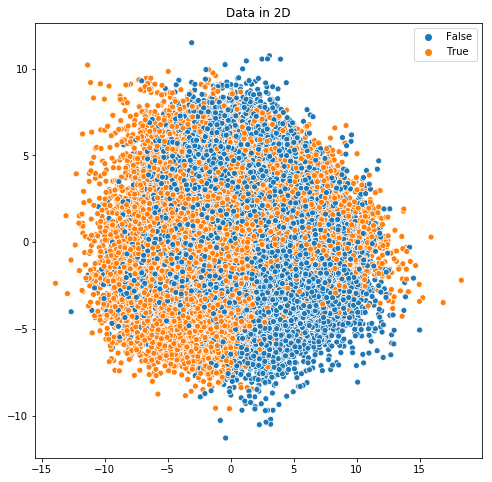

In [383]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=100000, n_features=7, n_informative=5, 
                    n_redundant=2, n_repeated=0, n_classes=2, n_clusters_per_class=6,class_sep=1.25,
                   flip_y=0.0,weights=[0.5,0.5])

X = pd.DataFrame(X,columns=['x','y','z','t','a','b','c'])
y = pd.Series(y)

visualize_2d(X,y,algorithm="pca")

# X,y = imbalance(X,y,pos_neg_frac=0.01,plot=False)
# print("="*100)
# visualize_2d(X,y)
# X,y = add_noise(X,y,noise_level = 0.1,noise_type = "randomize_labels",plot=False)
# visualize_2d(X,y)
# X_train, X_test, y_train, y_test = split(X,y,test_size=test_size)            
# classifier = build_model_xgb_scaled(scale_pos_weight=1)
# score = run_classifier(classifier,[precision_at_recall75],X_train,y_train,X_test,y_test,plot=True)
# score

In [384]:
def oversampling_vs_cweights(X,y,scorer,build_model,noise_type = "near_decision_boundary_labels"):
    X_org,y_org = X.copy(deep=True),y.copy(deep=True)
    noise_levels = [0,0.01,0.05,0.1]
    imbalances = [0.5,0.2,0.1,0.05,0.02,0.01]
    
    fig, axes = plt.subplots(2,2,figsize=(20,12))
    axes = list(more_itertools.flatten(axes))
    
    X_train, X_test, y_train, y_test = split(X_org,y_org)
    classifier = build_model(scale_pos_weight=1)
    score = run_classifier(classifier,[scorer],X_train,y_train,X_test,y_test,plot=False)
    ideal_train_score = score[scorer.__name__][0]
    no_imbalance_no_noise_perf = score[scorer.__name__][-1]
    
    for i,noise_level in enumerate(noise_levels):
        ax = axes[i]
        scores_cw = []
        scores_noaction=[]
        scores_oversample=[]
        
        
        X,y = add_noise(X_org,y_org,noise_level = noise_level,noise_type = noise_type,plot=False)
            
        X_train, X_test, y_train, y_test = split(X,y)

        classifier = build_model(scale_pos_weight=1)
        score = run_classifier(classifier,[scorer],X_train,y_train,X_test,y_test,plot=False)
        no_imbalance_train_score = score[scorer.__name__][0]
        no_imbalance_perf = score[scorer.__name__][-1]
            
        
        for imbalance_ratio in imbalances:
            X,y = imbalance(X_org,y_org,pos_neg_frac=imbalance_ratio,plot=False)
            X,y = add_noise(X,y,noise_level = noise_level,noise_type = noise_type,plot=False)
            
            X_train, X_test, y_train, y_test = split(X,y)
            
            classifier = build_model(scale_pos_weight=1)
            score = run_classifier(classifier,[scorer],X_train,y_train,X_test,y_test,plot=False)
            test_score = score[scorer.__name__][-1]
            scores_noaction.append(test_score)
            
            scale_pos_weight = min(max(int(np.sum(~y_train)/np.sum(y_train)),1),16)
            classifier = build_model(scale_pos_weight=scale_pos_weight)
            
            sample_weight = np.ones(y_train.shape)
            sample_weight[y_train==1] = scale_pos_weight
            score = run_classifier(classifier,[scorer],X_train,y_train,X_test,y_test,plot=False,sample_weight=sample_weight)
            test_score = score[scorer.__name__][-1]
            scores_cw.append(test_score)
            
            classifier = build_model(scale_pos_weight=1)
            pos_neg_frac = min(16*np.sum(y_train)/np.sum(~y_train),1)
            X_train,y_train = oversample(X_train,y_train,pos_neg_frac=pos_neg_frac,plot=False)
            score = run_classifier(classifier,[scorer],X_train,y_train,X_test,y_test,plot=False)
            test_score = score[scorer.__name__][-1]
            scores_oversample.append(test_score)
            
            # print(noise_level,imbalance_ratio,scale_pos_weight,pos_neg_frac)
            
        
        
        
        xticks = list(range(len(imbalances)))
        sns.lineplot(xticks,scores_noaction,label="No Oversampling/Weighing",ax=ax);
        sns.lineplot(xticks,scores_cw, label="Weighing",ax=ax);
        sns.lineplot(xticks,scores_oversample,label="Oversampling",ax=ax);
        
        for i,x in enumerate(xticks):
            ax.annotate("%.2f"%(scores_cw[i]),(x,scores_noaction[i]))
            
        
        ax.axhline(y=ideal_train_score,label="Ideal Train=%.3f"%(ideal_train_score),color='salmon')
        ax.axhline(y=no_imbalance_no_noise_perf,label="Ideal=%.3f"%(no_imbalance_no_noise_perf),color='r')
        
        ax.axhline(y=no_imbalance_train_score,label="No Imbalance Train=%.3f"%(no_imbalance_train_score),color='violet')
        ax.axhline(y=no_imbalance_perf,label="No Imbalance=%.3f"%(no_imbalance_perf),color='b')
        ax.legend();
        
        ax.set_title("Noise Level = %.0f%%, Metric = %s"%(noise_level*100,scorer.__name__));
        ax.xaxis.set_ticks(xticks)
        xticklabels = ["%.2f"%x for x in imbalances]
        ax.xaxis.set_ticklabels(xticklabels)
        ax.set_ylim((0,1.1))
        
        ax.set_ylabel(scorer.__name__)
        ax.set_xlabel("Imbalance --> Increasing")
    plt.show();
            
            
            

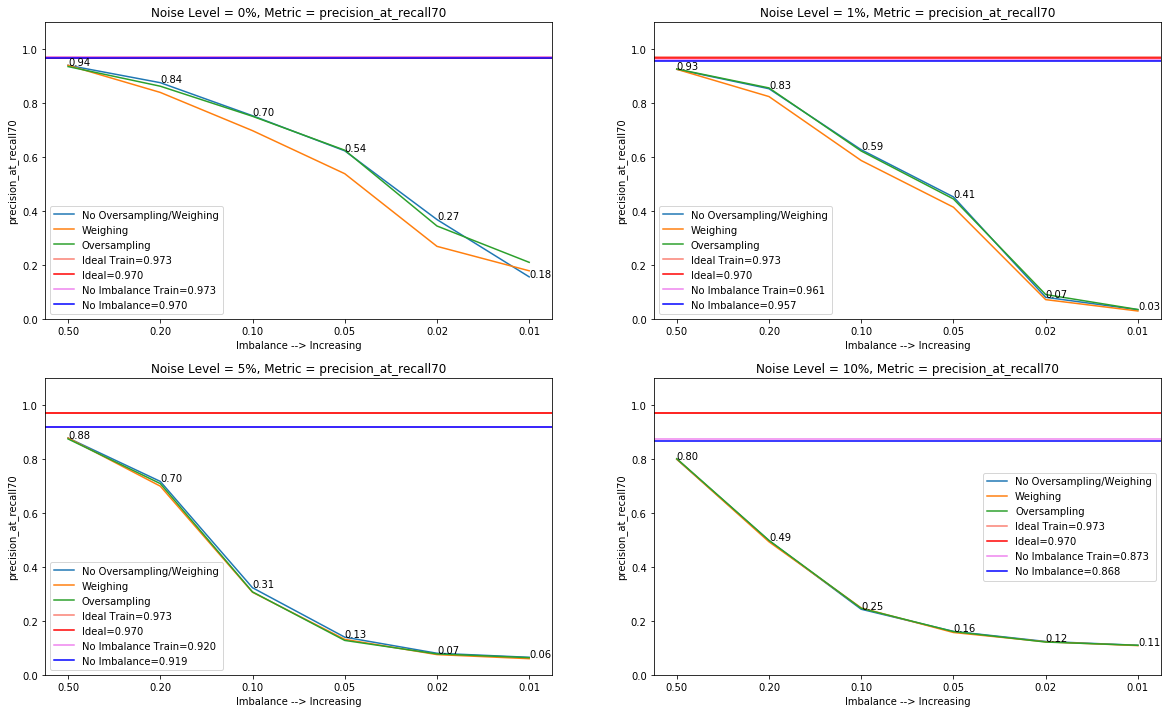

In [385]:
def build_model_xgb_scaled(scale_pos_weight=1):
    classifier = XGBClassifier(n_estimators=50,max_depth=4,scale_pos_weight=scale_pos_weight,n_jobs=2)
    return classifier

def build_model_rb(scale_pos_weight=None):
    classifier = RUSBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),n_estimators=50, 
                                    learning_rate=0.1, algorithm='SAMME.R', 
                                    sampling_strategy='auto', replacement=False)
    return classifier

def precision_at_recall70(y,y_pred,y_score):
    from sklearn.metrics import precision_recall_curve
    precision, recall, _ = precision_recall_curve(y, y_score)
    return precision[recall>0.7][-1]

oversampling_vs_cweights(X,y,precision_at_recall70,build_model_xgb_scaled, noise_type = "randomize_labels")

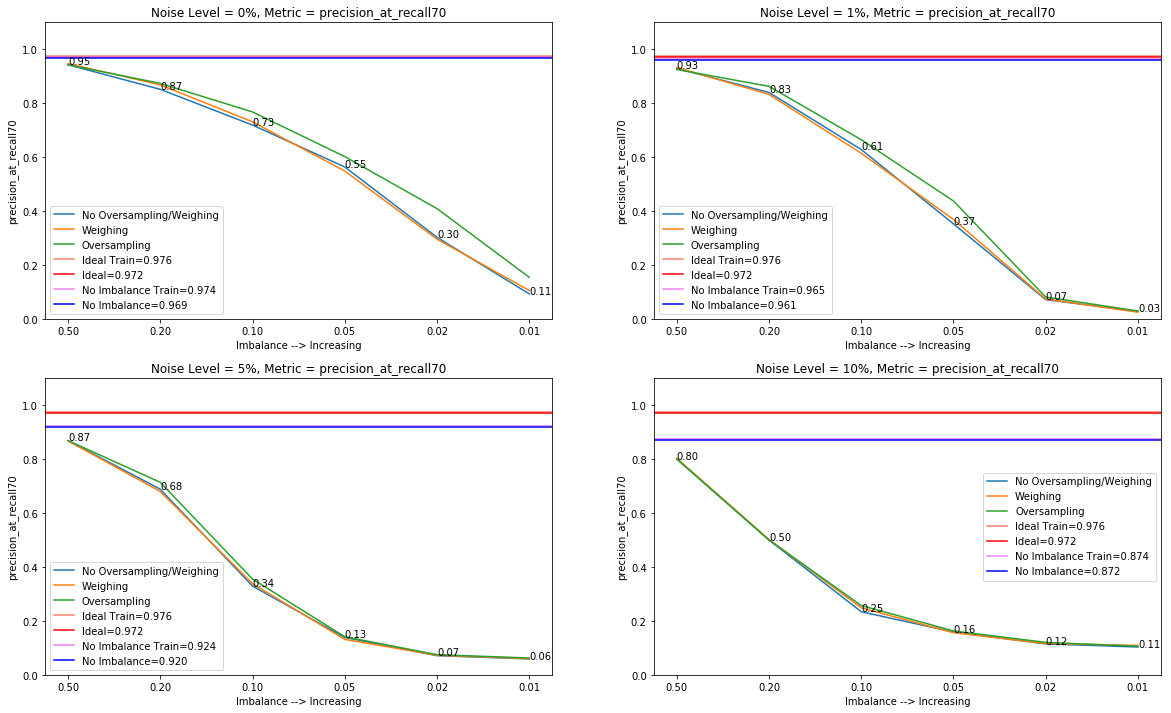

In [386]:
oversampling_vs_cweights(X,y,precision_at_recall70,build_model_rb, noise_type = "randomize_labels")

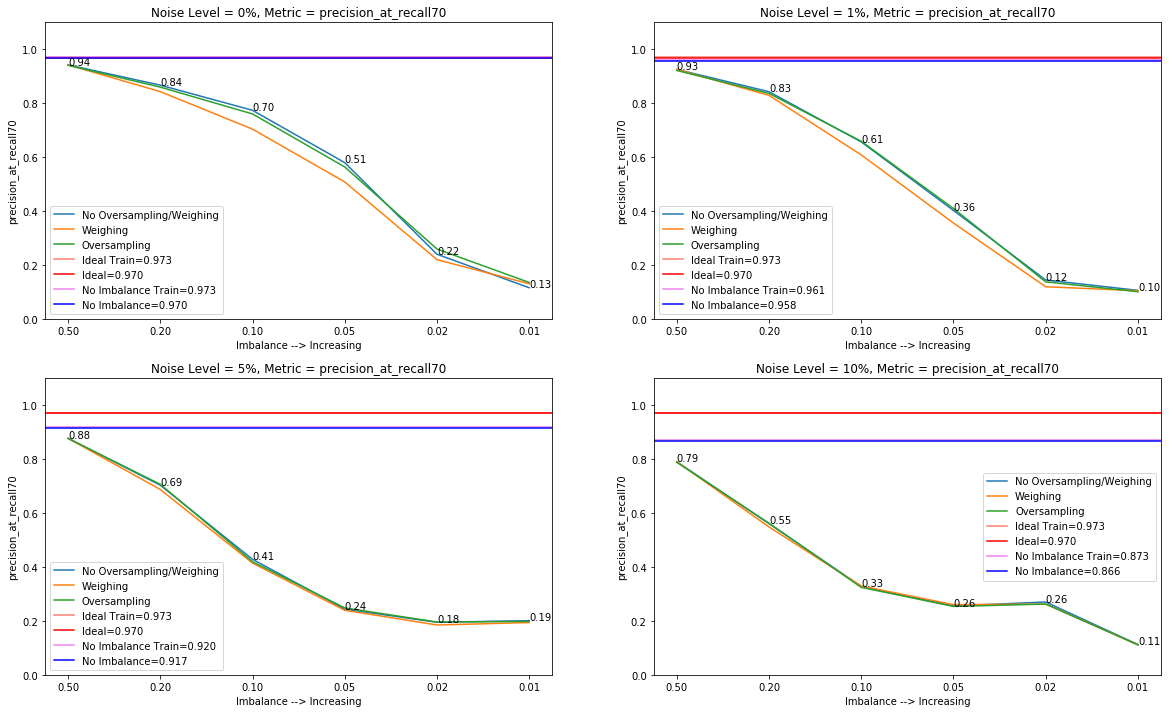

In [388]:
oversampling_vs_cweights(X,y,precision_at_recall70,build_model_xgb_scaled)

In [387]:
gc.collect()

29939

### Oversampling vs No Action

In [389]:
def oversampling_vs_noaction(X,y,scorer,build_model,noise_type = "near_decision_boundary_labels"):
    X_org,y_org = X.copy(deep=True),y.copy(deep=True)
    noise_levels = [0,0.01,0.05,0.1]
    imbalances = [0.5,0.2,0.1,0.05,0.02,0.01]
    
    fig, axes = plt.subplots(2,2,figsize=(20,12))
    axes = list(more_itertools.flatten(axes))
    
    X_train, X_test, y_train, y_test = split(X_org,y_org)
    classifier = build_model(scale_pos_weight=1)
    score = run_classifier(classifier,[scorer],X_train,y_train,X_test,y_test,plot=False)
    ideal_train_score = score[scorer.__name__][0]
    no_imbalance_no_noise_perf = score[scorer.__name__][-1]
    
    for i,noise_level in enumerate(noise_levels):
        ax = axes[i]
        scores_noaction=[]
        scores_oversample=[]
        
        
        X,y = add_noise(X_org,y_org,noise_level = noise_level,noise_type = noise_type,plot=False)
            
        X_train, X_test, y_train, y_test = split(X,y)

        classifier = build_model(scale_pos_weight=1)
        score = run_classifier(classifier,[scorer],X_train,y_train,X_test,y_test,plot=False)
        no_imbalance_train_score = score[scorer.__name__][0]
        no_imbalance_perf = score[scorer.__name__][-1]
            
        
        for imbalance_ratio in imbalances:
            X,y = imbalance(X_org,y_org,pos_neg_frac=imbalance_ratio,plot=False)
            X,y = add_noise(X,y,noise_level = noise_level,noise_type = noise_type,plot=False)
            
            X_train, X_test, y_train, y_test = split(X,y)
            
            classifier = build_model(scale_pos_weight=1)
            score = run_classifier(classifier,[scorer],X_train,y_train,X_test,y_test,plot=False)
            test_score = score[scorer.__name__][-1]
            scores_noaction.append(test_score)
            
            
            
            classifier = build_model(scale_pos_weight=1)
            pos_neg_frac = min(16*np.sum(y_train)/np.sum(~y_train),1)
            X_train,y_train = oversample(X_train,y_train,pos_neg_frac=pos_neg_frac,plot=False)
            score = run_classifier(classifier,[scorer],X_train,y_train,X_test,y_test,plot=False)
            test_score = score[scorer.__name__][-1]
            scores_oversample.append(test_score)
            
            # print(noise_level,imbalance_ratio,scale_pos_weight,pos_neg_frac)
            
        
        
        
        xticks = list(range(len(imbalances)))
        sns.lineplot(xticks,scores_noaction,label="No Oversampling/Weighing",ax=ax);
        sns.lineplot(xticks,scores_oversample,label="Oversampling",ax=ax);
        
        for i,x in enumerate(xticks):
            ax.annotate("%.2f"%(scores_oversample[i]),(x,scores_noaction[i]))
            
        
        ax.axhline(y=ideal_train_score,label="Ideal Train=%.3f"%(ideal_train_score),color='salmon')
        ax.axhline(y=no_imbalance_no_noise_perf,label="Ideal=%.3f"%(no_imbalance_no_noise_perf),color='r')
        
        ax.axhline(y=no_imbalance_train_score,label="No Imbalance Train=%.3f"%(no_imbalance_train_score),color='violet')
        ax.axhline(y=no_imbalance_perf,label="No Imbalance=%.3f"%(no_imbalance_perf),color='b')
        ax.legend();
        
        ax.set_title("Noise Level = %.0f%%, Metric = %s"%(noise_level*100,scorer.__name__));
        ax.xaxis.set_ticks(xticks)
        xticklabels = ["%.2f"%x for x in imbalances]
        ax.xaxis.set_ticklabels(xticklabels)
        ax.set_ylim((0,1.1))
        
        ax.set_ylabel(scorer.__name__)
        ax.set_xlabel("Imbalance --> Increasing")
    plt.show();
            
            

In [ ]:
def build_model_nn(scale_pos_weight=1):
    classifier = XGBClassifier(n_estimators=50,max_depth=4,scale_pos_weight=scale_pos_weight,n_jobs=2)
    return classifier

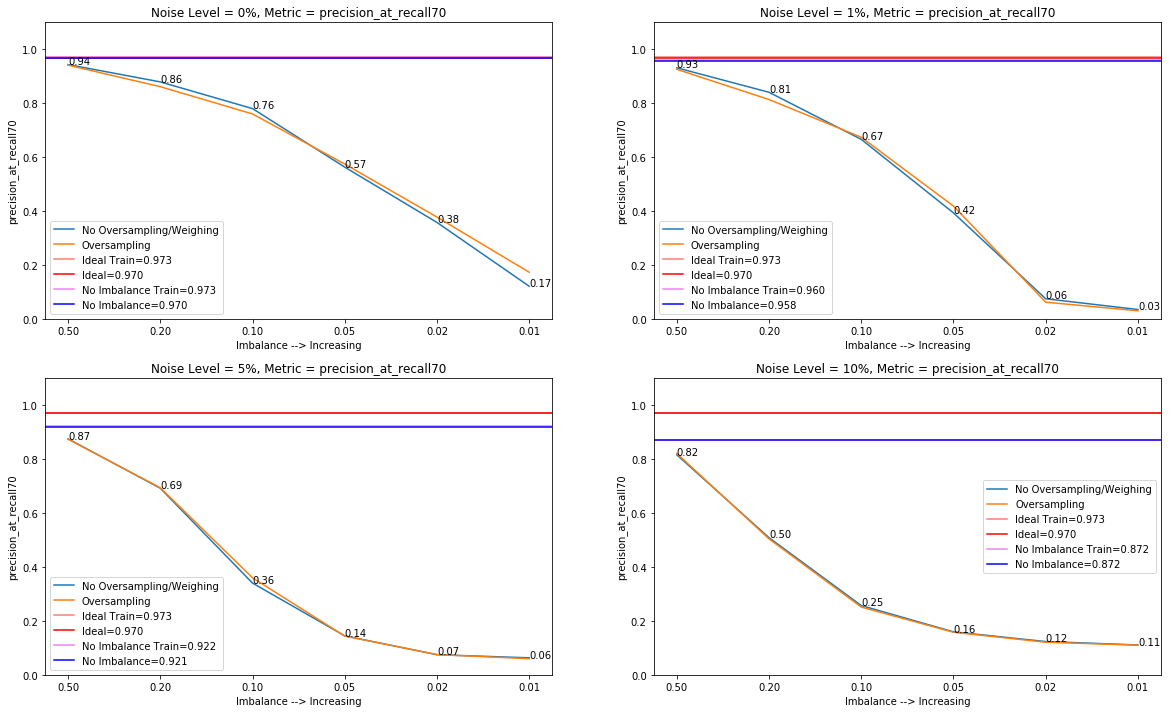

In [390]:
oversampling_vs_noaction(X,y,precision_at_recall70,build_model_xgb_scaled, noise_type = "randomize_labels")

### Test Oversampling vs No Action on NN

# Observations

## Adding Noise to Imbalanced Data
Once the noise is above the lowest class count, the data mostly loses the signal.

In [ ]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=10000, n_features=7, n_informative=5, 
                    n_redundant=2, n_repeated=0, n_classes=2, n_clusters_per_class=6,class_sep=1.25,
                   flip_y=0.0,weights=[0.5,0.5])

X = pd.DataFrame(X,columns=['x','y','z','t','a','b','c'])
y = pd.Series(y)

visualize_2d(X,y,algorithm="tsne")

# X,y = imbalance(X,y,pos_neg_frac=0.01,plot=False)
# print("="*100)
# visualize_2d(X,y)
# X,y = add_noise(X,y,noise_level = 0.1,noise_type = "randomize_labels",plot=False)
# visualize_2d(X,y)
# X_train, X_test, y_train, y_test = split(X,y,test_size=test_size)            
# classifier = build_model_xgb_scaled(scale_pos_weight=1)
# score = run_classifier(classifier,[precision_at_recall75],X_train,y_train,X_test,y_test,plot=True)
# score

## Oversampling Noisy Data
Mostly increases the noise, be very sure your data isn't noisy before oversampling.
Better use scale_pos_weight





### Is Oversampling is ok if there is Random Noise?
Performance of XGBoost with and without SMOTE oversampling

### Is oversampling bad for errors near decision boundary?

## Boundary Noise vs Random Label Noise

Boundary Noise should make it harder.


In case of errors near boundary:
Notice how in presence of noise the decision boundary shifts towards the majority class. This occurs because while error is present in both classes, the majority class has more examples. As a result majority class has more errors near the boundary. These errors simply mean that within the area of majority class and near the border, it will have multiple samples marked as minority class.
Now if we over-sample minority class, and since over-samples usually use nearest neighbors, these border areas will get a lot of minority class examples on the wrong side.

### How do we know if we have noise near decision boundary or random noise?



### Boundary Noise with Imbalance gives more FP, compared to Random Label Noise

# Interactive

## Generate or read data

In [ ]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=10000, n_features=3, n_informative=3, 
                    n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=3,class_sep=1.5,
                   flip_y=0.0,weights=[0.5,0.5])

X = pd.DataFrame(X,columns=['x','y','z'])
y = pd.Series(y)

visualize_2d(X,y,algorithm="tsne")

## Imbalance the Data

- What happens when imbalance if different in train and test data. We will imbalance train and test data separately for this.


## Make some Noise

- Realise how the model performs with incremental noise
- Realise what would happen if we removed some noise from data
    - If model performs bad just by adding little noise then our model is brittle to noise.
    - It means that if the real data had even 1% noise and we removed it then our model performance will increase a lot.
    
- What happens if Noise profile for your train and test data are different?
    - for example training data was gathered by experts in Lab but test data is gathered by IOT devices on field.

## Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Oversample

Why do we over-sample after adding noise?
In Real world your data will already come with some noise and this noise cannot be removed in our preprocessing. As such 

## Inspect your Data
- Imbalance/Noise

## Model

## Show Metrics (CV and Test)

## Learning Curves

# Appendix

## Finding Optimal Trees for XGBoost

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=63, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

<Figure size 1008x720 with 0 Axes>

Text(0.5,1,'Training and Test Loss (Last 3 Training): [0.13368, 0.13335, 0.13297] (Last 3 Test): [0.173011, 0.172681, 0.172473]')

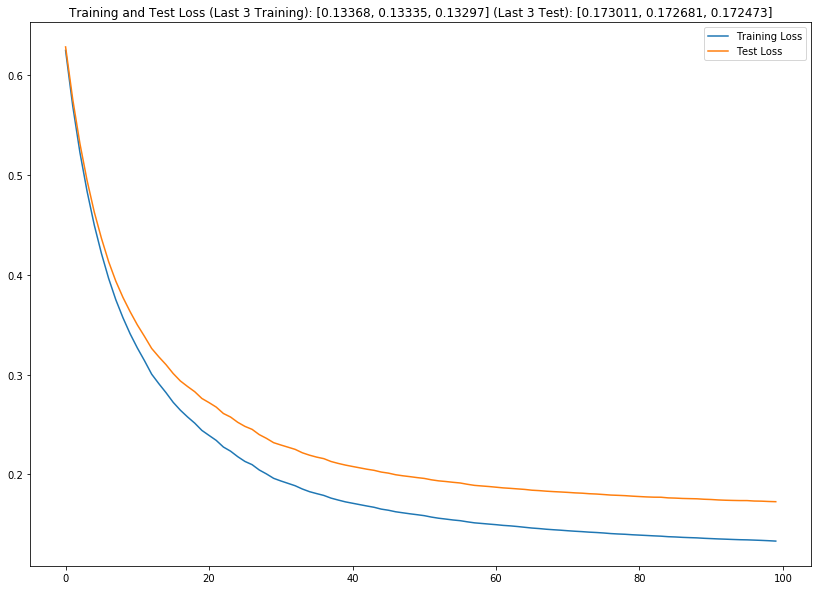

In [302]:


model = XGBClassifier(max_depth=3,n_estimators=100,learning_rate=0.1,
                              n_jobs=os.cpu_count()-1,scale_pos_weight=1)

training_loss = []
test_loss = []

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2)
eval_set = [(X_tr, y_tr), (X_val, y_val)]
model.fit(X_tr, y_tr, eval_metric=["logloss"], eval_set=eval_set,verbose=False)
results = model.evals_result()
training_loss.extend(results['validation_0']['logloss'])
test_loss.extend(results['validation_1']['logloss'])


plt.figure(figsize=(14,10))
plt.plot(training_loss,label="Training Loss")
plt.plot(test_loss,label="Test Loss")
plt.title("Training and Test Loss (Last 3 Training): %s (Last 3 Test): %s"%(training_loss[-3:],test_loss[-3:]))
plt.legend()
plt.show()